In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

from scipy import stats

from dependencies import (
    perform_kmeans_clustering, 
    get_annual_return, 
    perform_polynomial_on_clustering, 
    combine_polynomial_plots,
    POLYNOMIAL_DEGREE
)

In [2]:
data_frame = pd.read_csv('datasets/S&P500_EOD-Price.csv')
data_frame = data_frame.dropna(axis=1)

data_frame.head()

Date        APA      MTCH       GEN        DXC       EG      BKR  \
0  2000-01-03  14.772727  7.527071  7.109375  46.327873  21.8750  20.2500   
1  2000-01-04  14.123377  6.921444  6.781250  46.017365  21.8125  20.2500   
2  2000-01-05  14.529221  6.661890  6.375000  42.788074  23.2500  20.3750   
3  2000-01-06  15.909091  6.938748  6.007813  43.409092  24.3125  22.3125   
4  2000-01-07  15.854978  6.904141  6.484375  43.315941  25.6250  23.8125   

      AMD        HON      BALL  ...       SNPS       SWKS     ZION      TTWO  \
0  15.500  54.044136  2.488281  ...  32.781250  31.406250  55.5000  9.125000   
1  14.625  53.090767  2.406250  ...  30.437500  29.562500  52.8125  8.875000   
2  15.000  52.375736  2.449219  ...  30.703125  30.328125  52.7500  8.833333   
3  16.000  53.388695  2.488281  ...  28.468750  27.375000  53.5000  8.750000   
4  16.250  56.248802  2.417969  ...  28.750000  30.187500  53.6250  9.000000   

       VRTX      TRMB       ZBRA       LNT       BBWI      WBA  
0  18.78125  4.145833  25.027779  13.40625  16.395514  28.5625  
1  17.28125  4.072917  24.666668  13.40625  16.067099  27.5000  
2  17.00000  3.817708  25.138889  14.06250  15.839733  27.8125  
3  16.75000  3.854167  23.777779  14.06250  15.587106  27.0000  
4  18.21875  3.854167  23.513889  14.25000  15.688157  27.6875  

[5 rows x 366 columns]

In [6]:
data_frame["Date"] = pd.to_datetime(data_frame["Date"])
data_frame['Year'] = data_frame["Date"].dt.year
data_frame["Quarter"] = data_frame["Date"].dt.quarter

start_year = 2000
end_year = 2017
quarters = [1, 2, 3, 4]

data_frame_rolling_returns = []

for year in range(start_year, end_year): 
    for quarter in quarters:
        filtered_data_frame_1 = data_frame[((data_frame['Year'] == year) & (data_frame['Quarter'] >= quarter))]
        filtered_data_frame_2 = data_frame[((data_frame['Year'] >= year + 1) & (data_frame['Year'] <= year + 6))]
        filtered_data_frame_3 = data_frame[((data_frame['Year'] == year + 7) & (data_frame['Quarter'] < quarter))]
        
        filtered_data = pd.concat([filtered_data_frame_1, filtered_data_frame_2, filtered_data_frame_3])
        filtered_data = filtered_data.reset_index(drop=True)
        
        for column in filtered_data.columns:
            if column not in ["Date", "Year", "Quarter"] and not filtered_data.empty:
                rolling_return = get_annual_return(filtered_data[column].iloc[0], filtered_data[column].iloc[-1])
                rolling_returns = [get_annual_return(filtered_data[column].iloc[0], filtered_data[column].iloc[i]) for i in range(len(filtered_data))]  
                relative_percentile = stats.percentileofscore(rolling_returns, rolling_return)
                data_frame_rolling_returns.append({'Stock': column, 'Year': year, 'Quarter': quarter, 'Rolling_Return': rolling_return, 'Relative_Percentile': relative_percentile})

data_frame_rolling_percentile = pd.DataFrame(data_frame_rolling_returns)
data_frame_rolling_percentile.head(100)


Stock  Year  Quarter  Rolling_Return  Relative_Percentile
0    APA  2000        1      350.221560            86.611711
1   MTCH  2000        1       23.012417            91.188175
2    GEN  2000        1      193.274725            77.174531
3    DXC  2000        1      -42.766757            73.479250
4     EG  2000        1      348.502862            92.268334
..   ...   ...      ...             ...                  ...
95   WEC  2000        1      148.970492            99.033542
96   ECL  2000        1      139.867335            98.237635
97   LEG  2000        1       16.231003            63.359864
98   NEE  2000        1      163.854545            99.488346
99   CCI  2000        1        5.793241            83.683911

[100 rows x 5 columns]

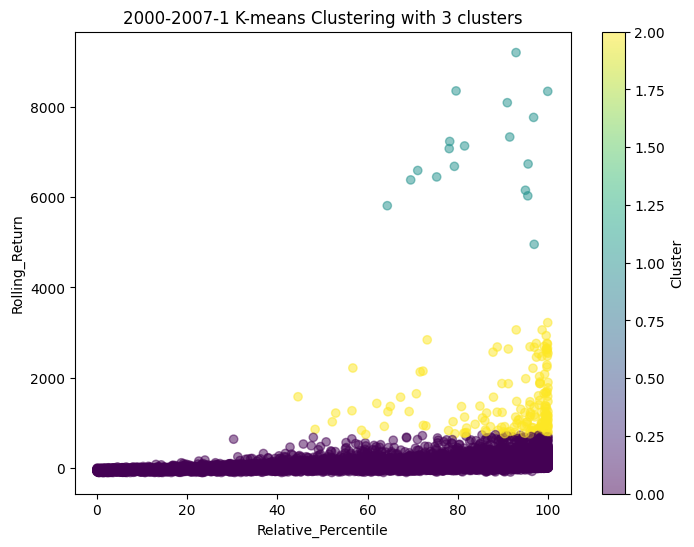

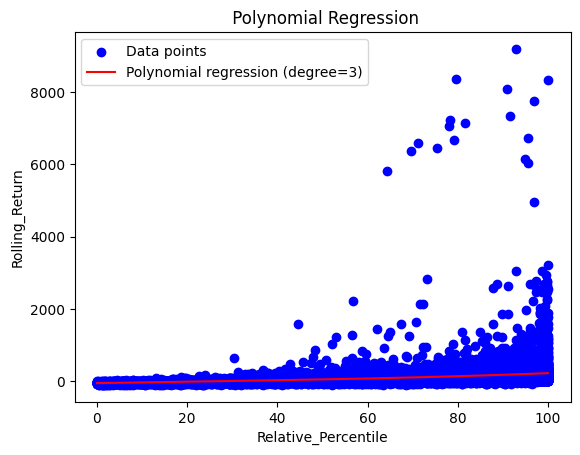

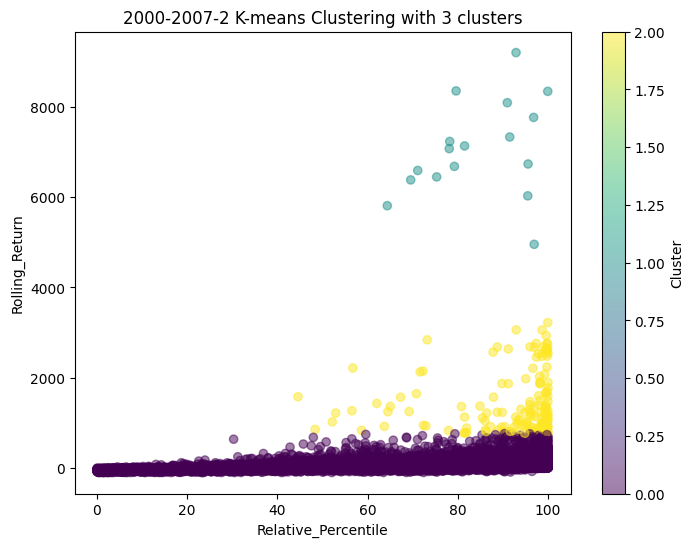

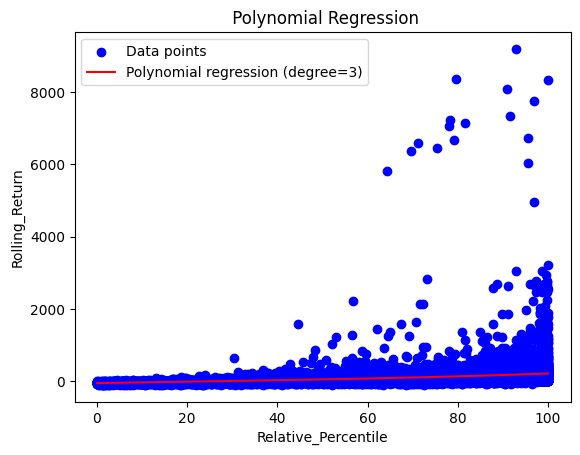

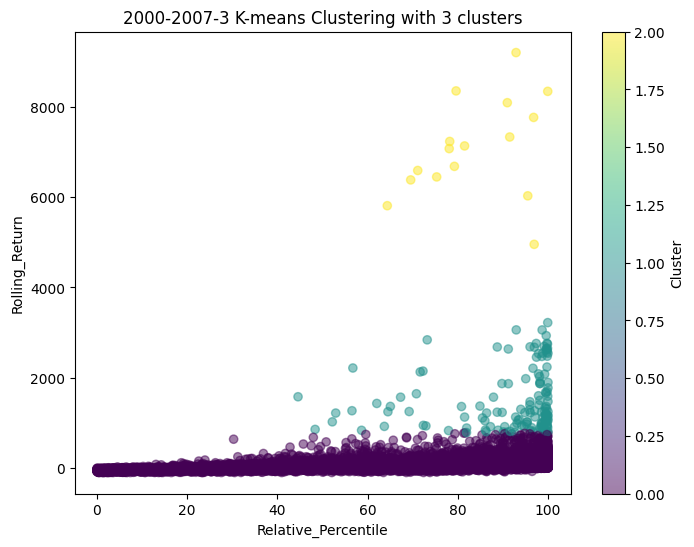

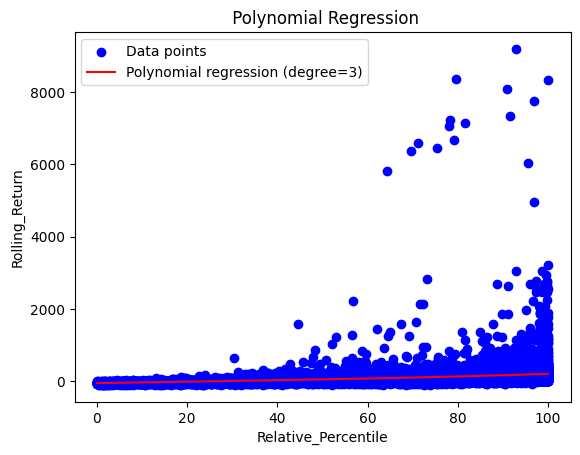

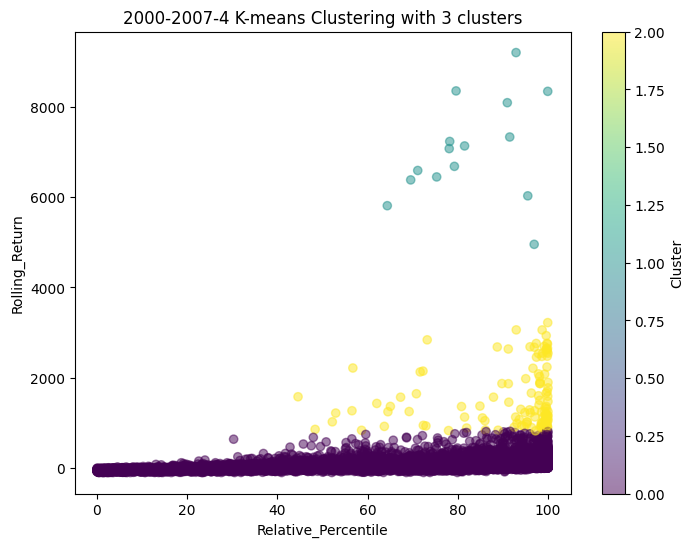

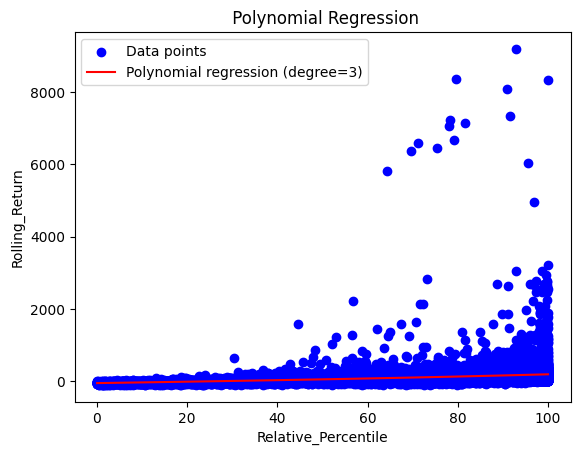

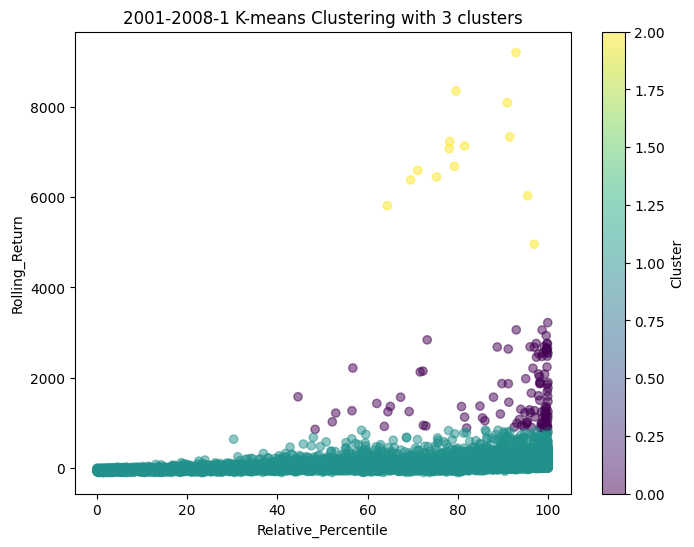

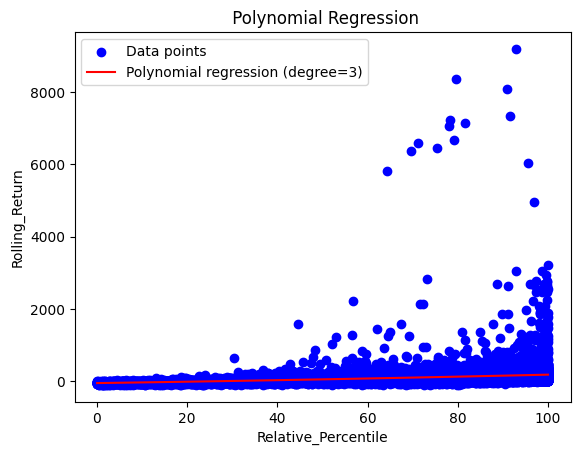

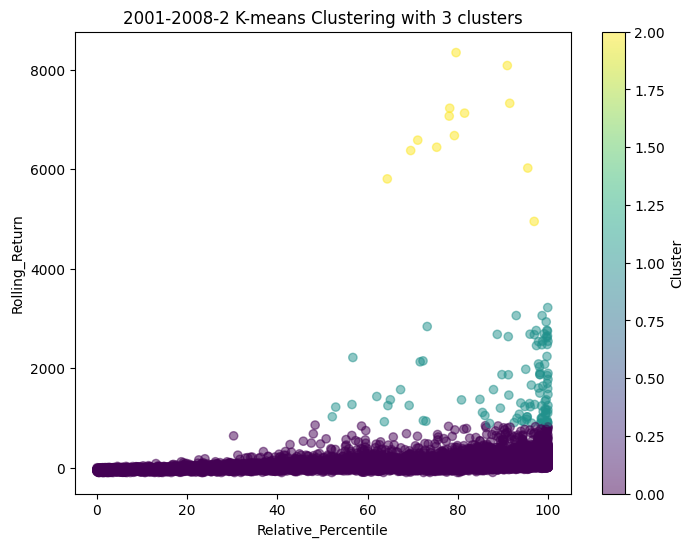

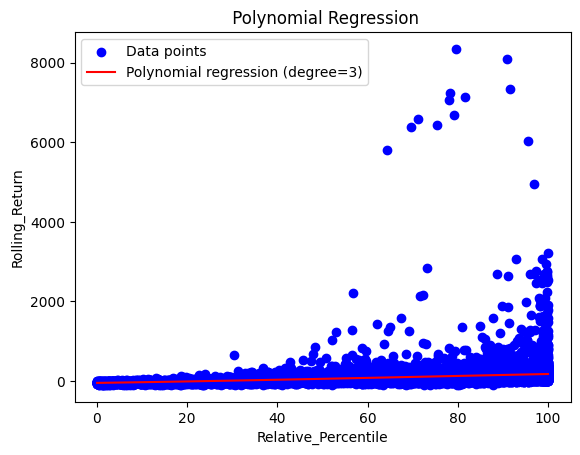

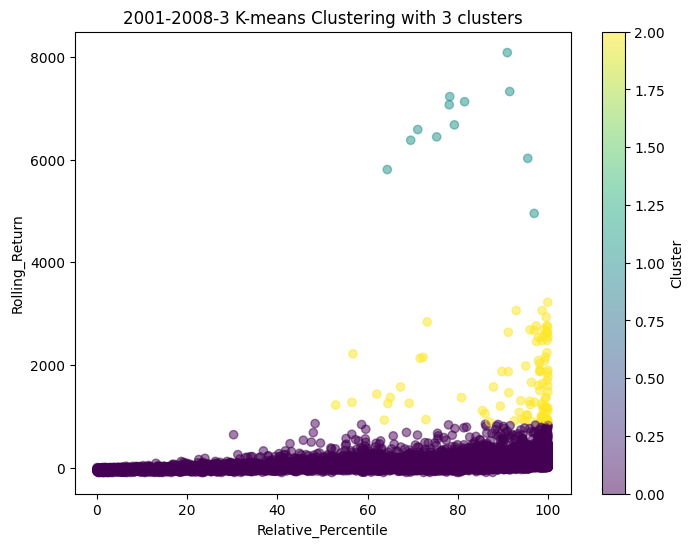

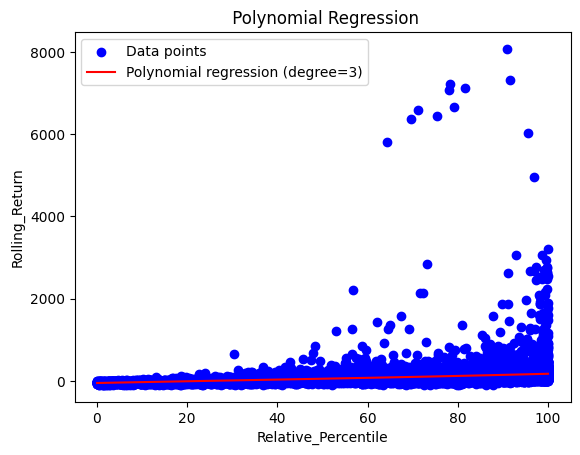

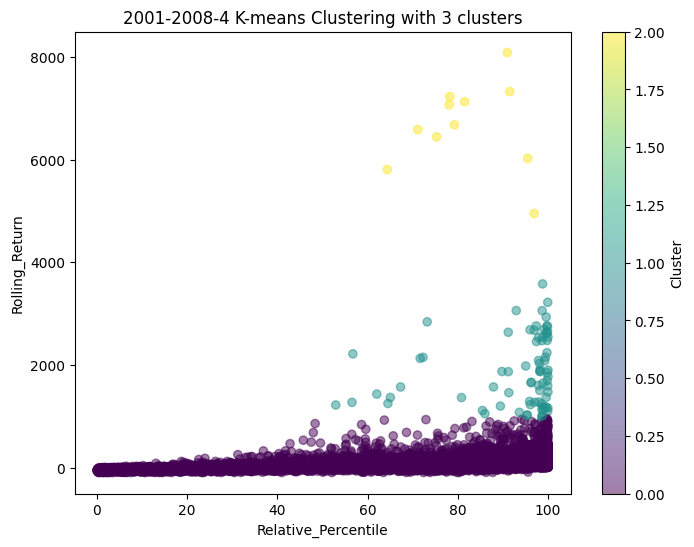

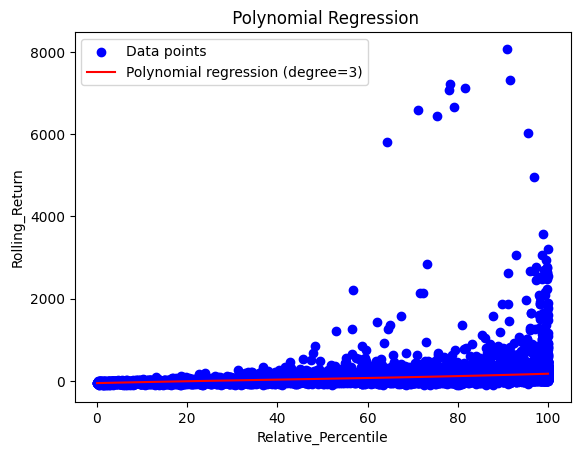

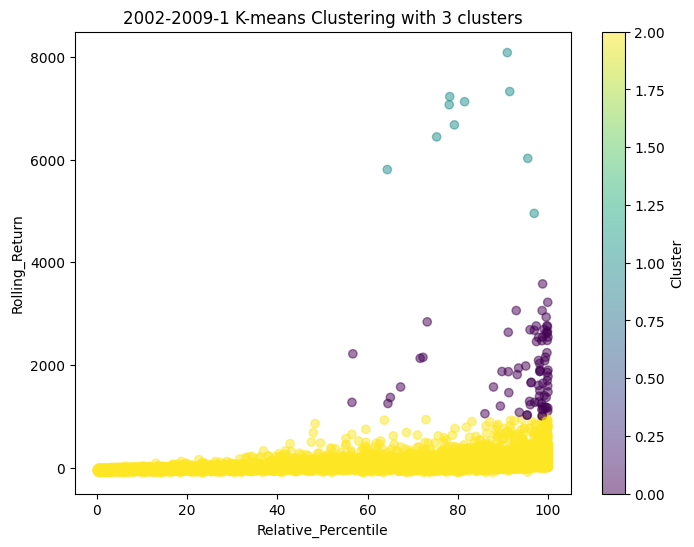

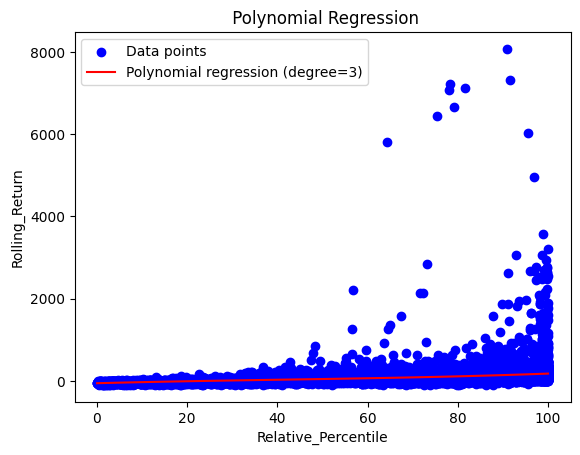

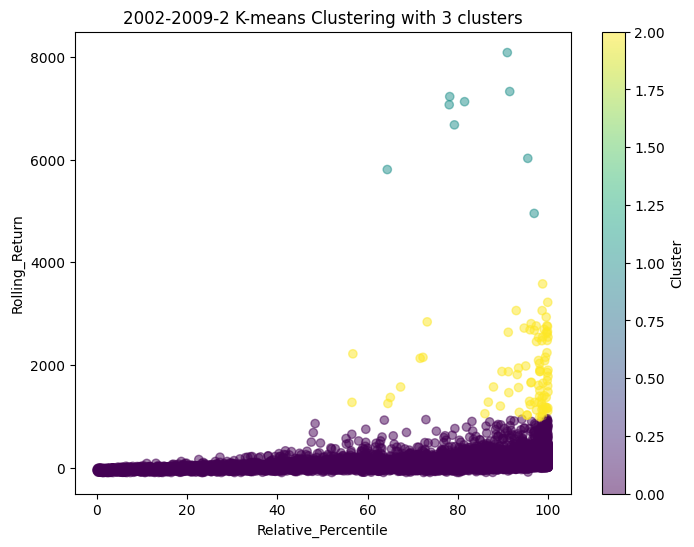

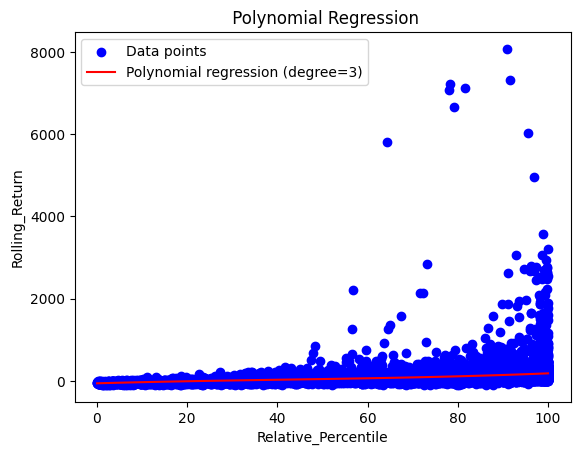

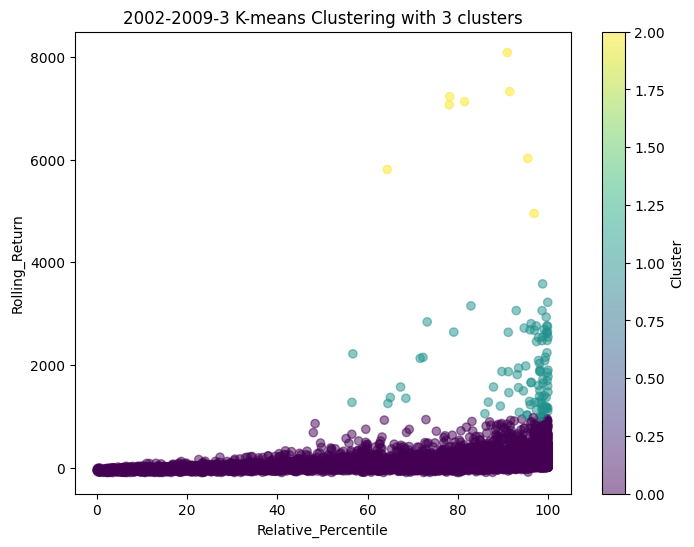

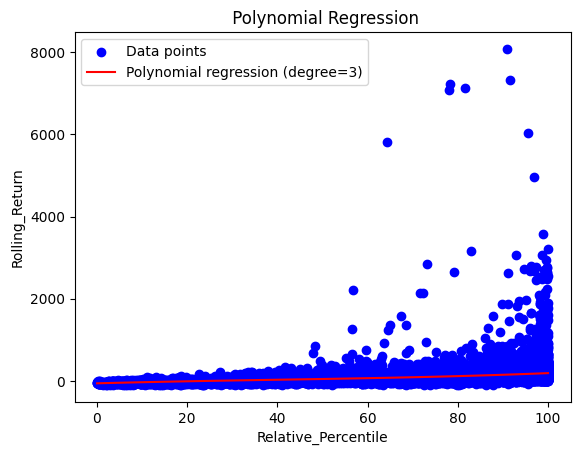

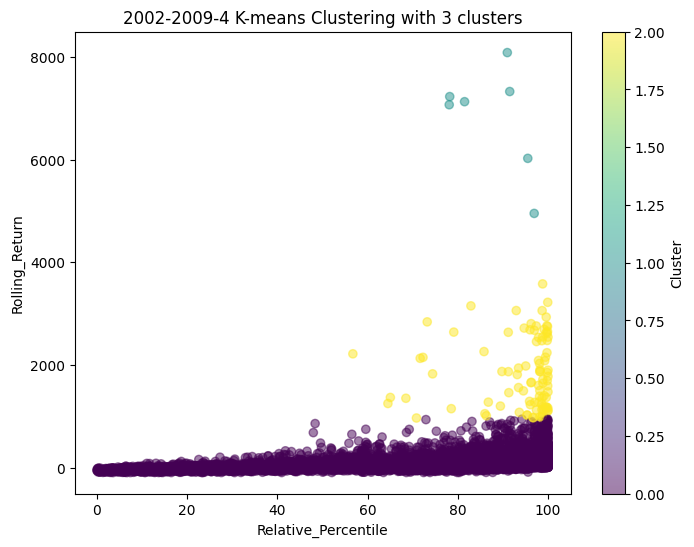

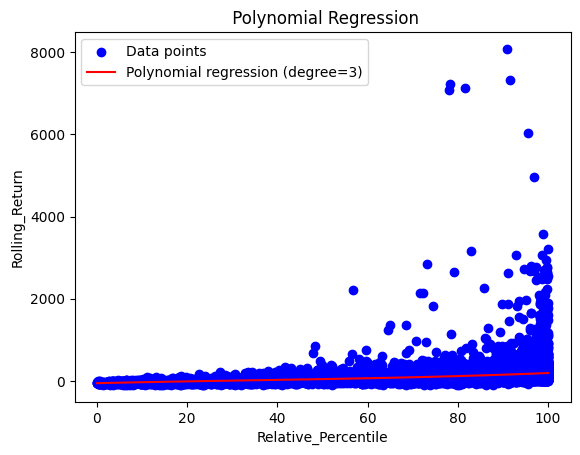

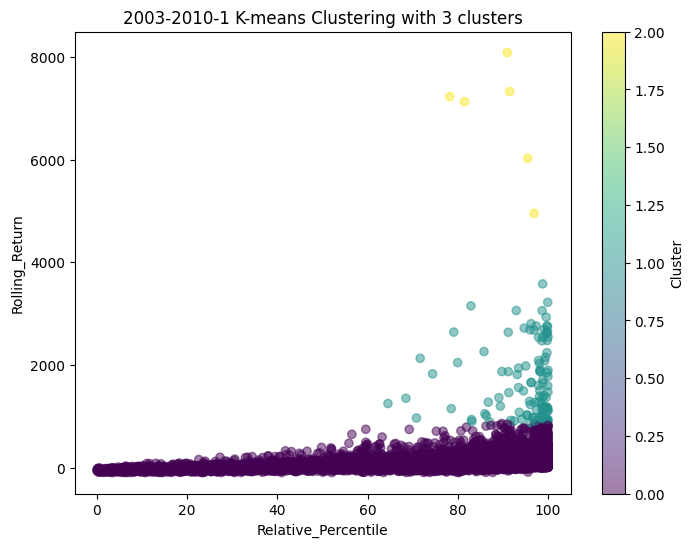

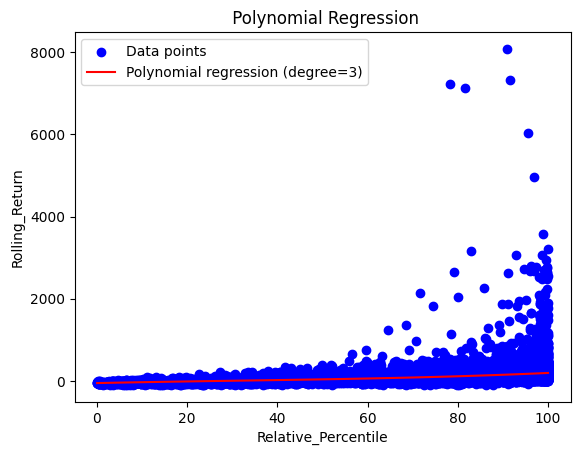

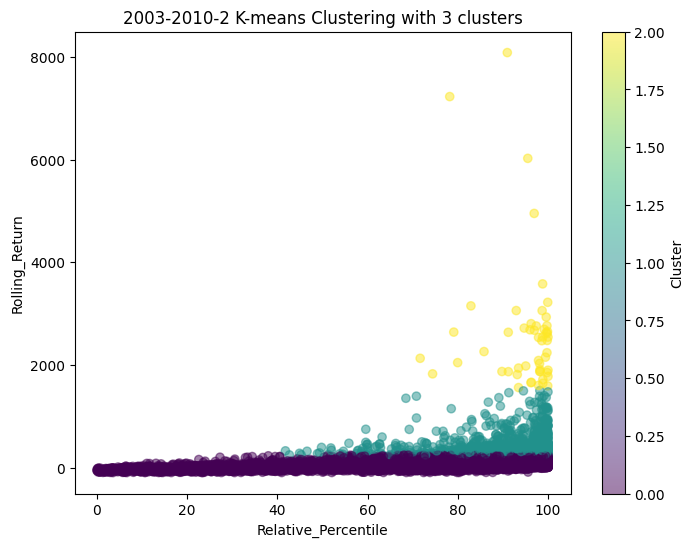

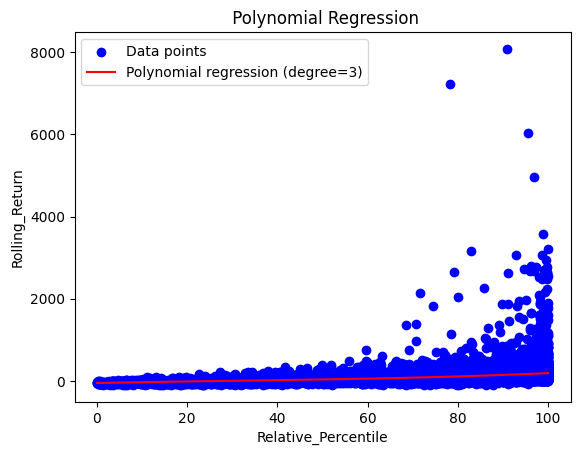

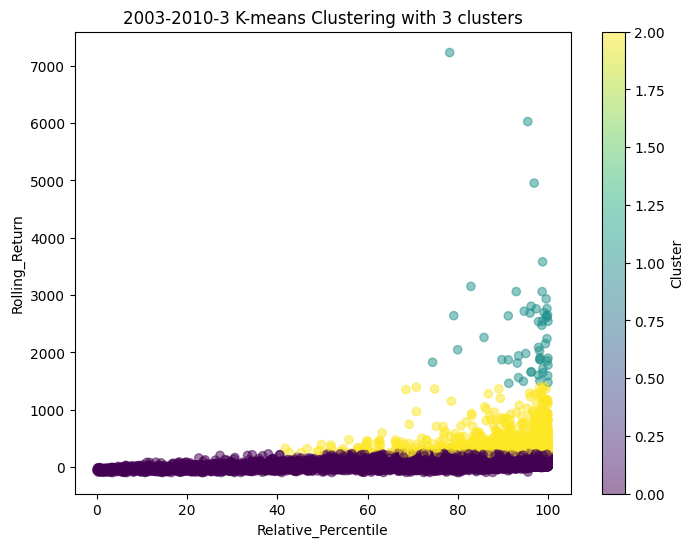

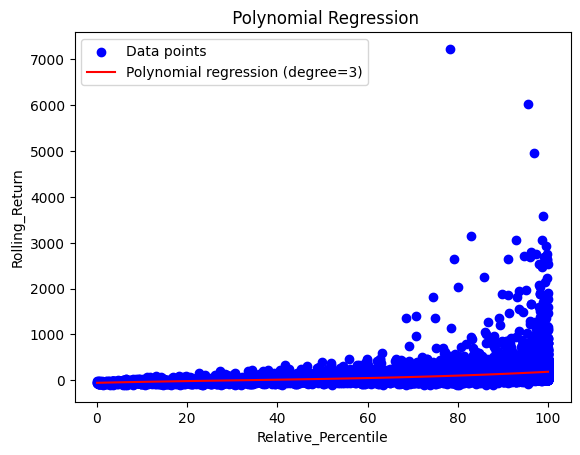

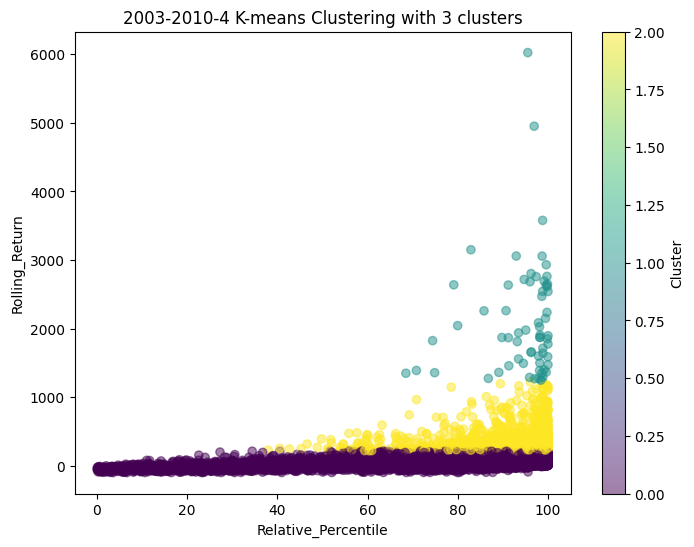

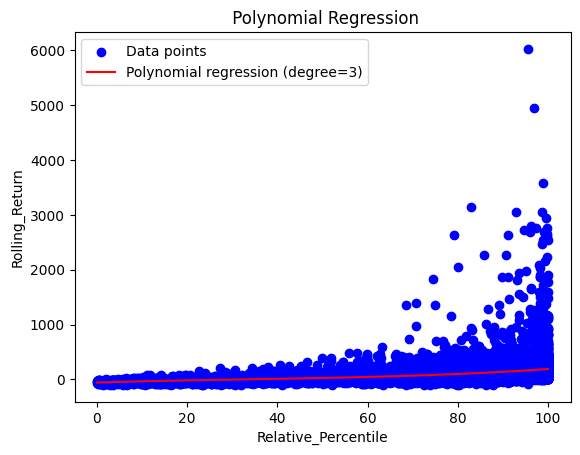

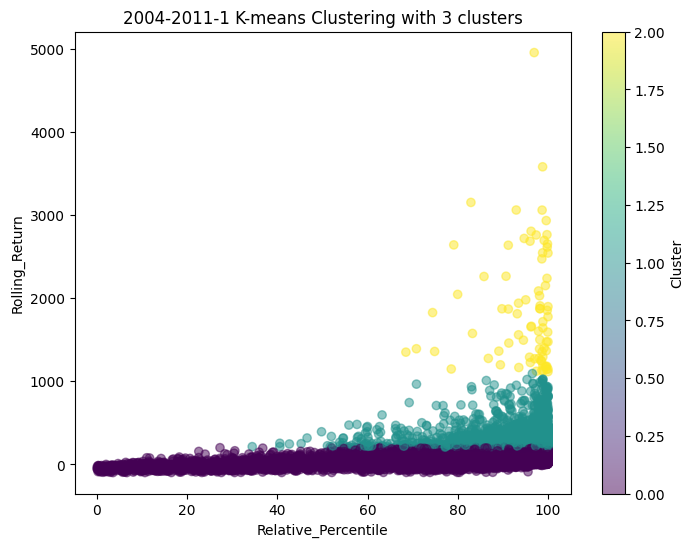

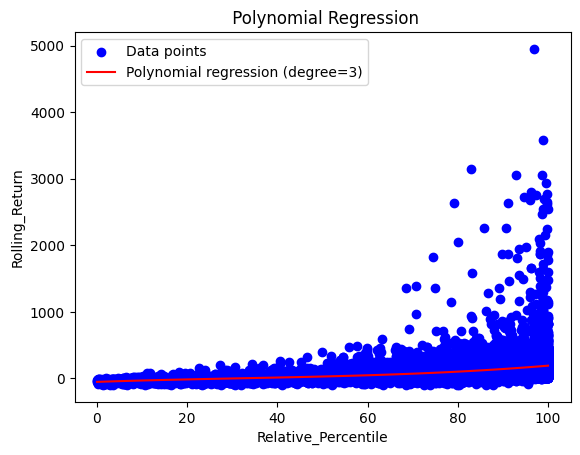

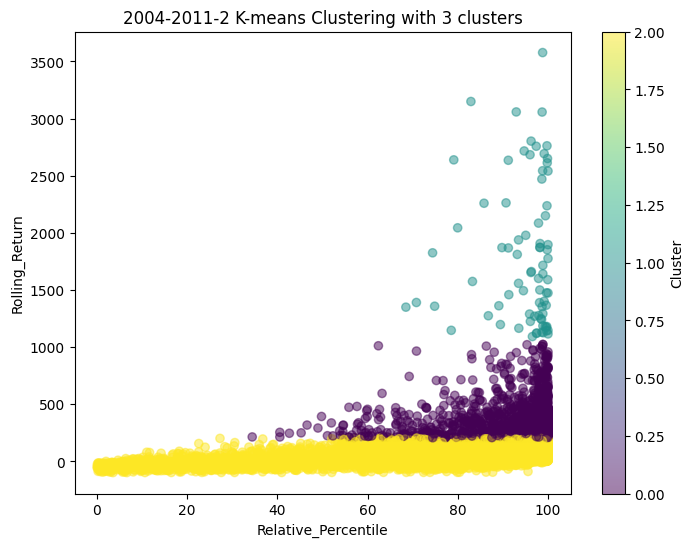

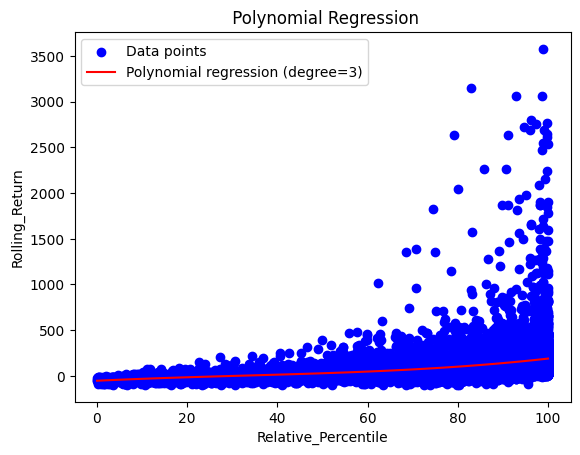

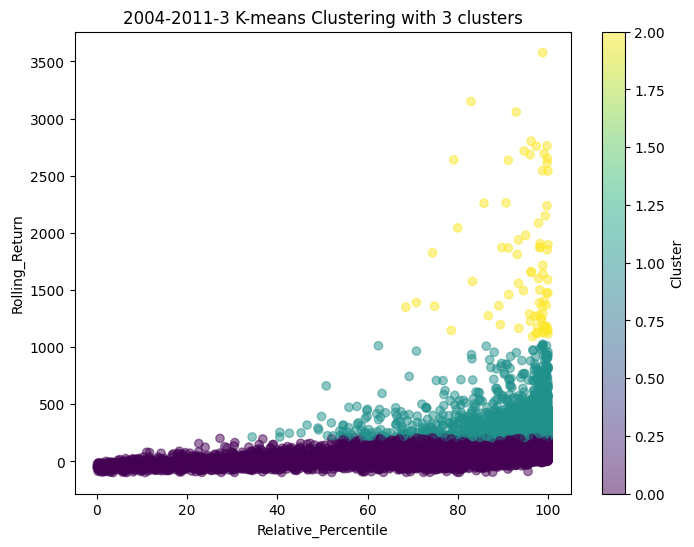

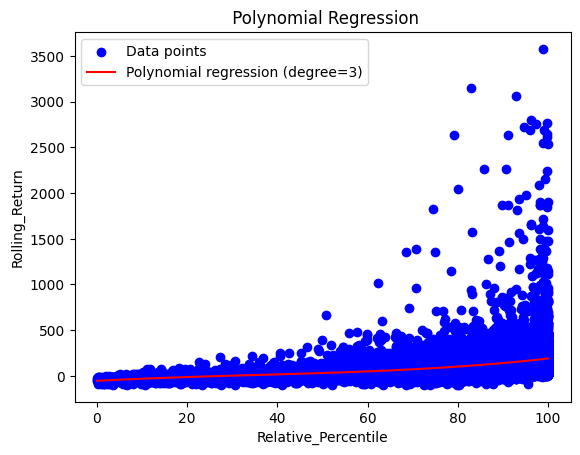

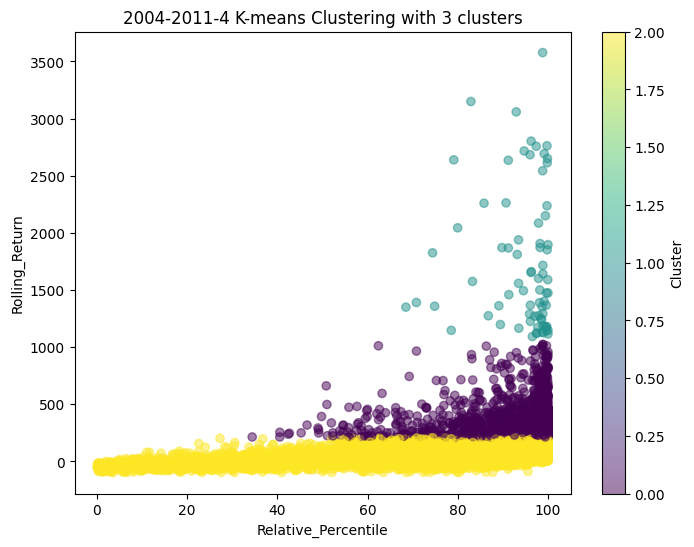

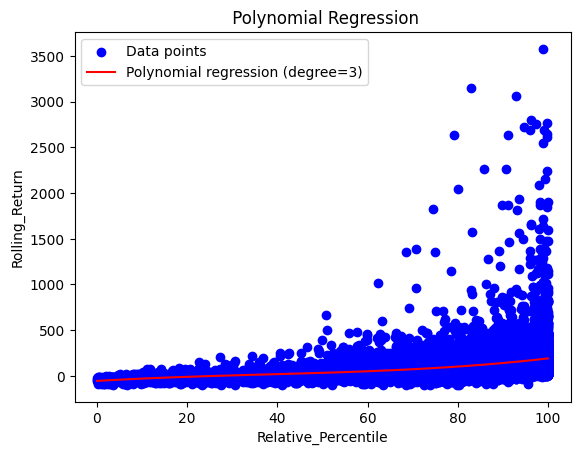

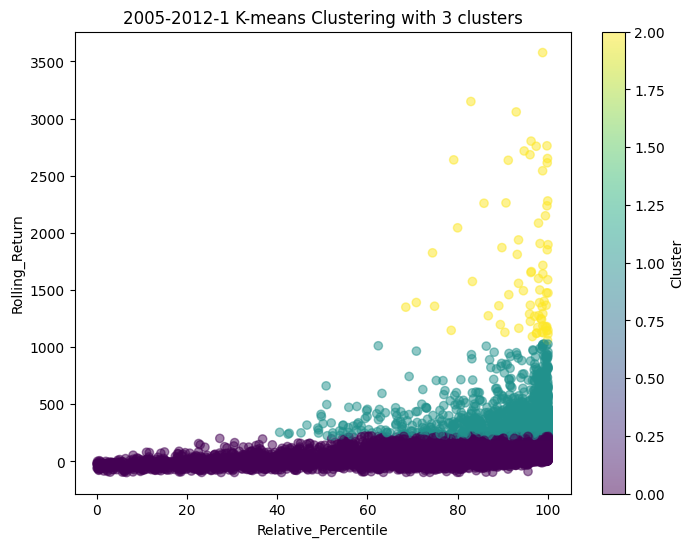

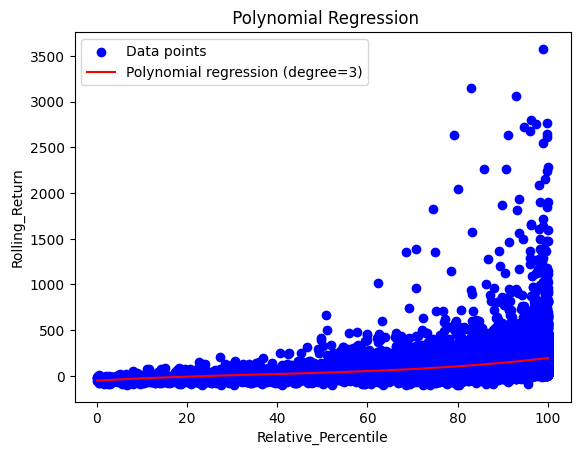

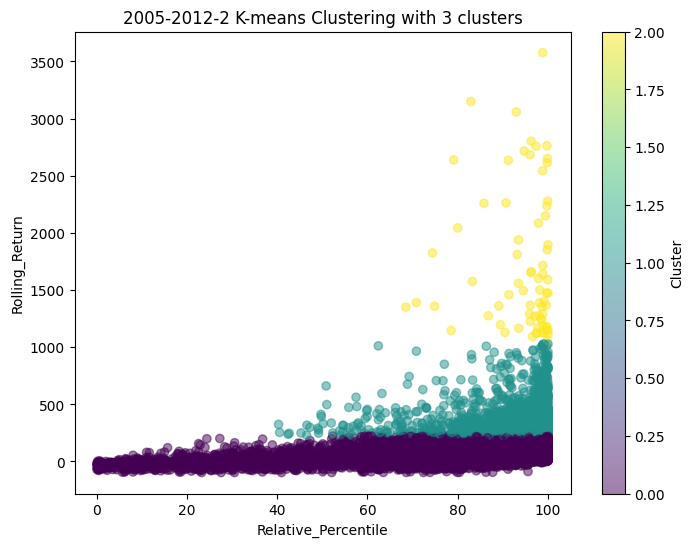

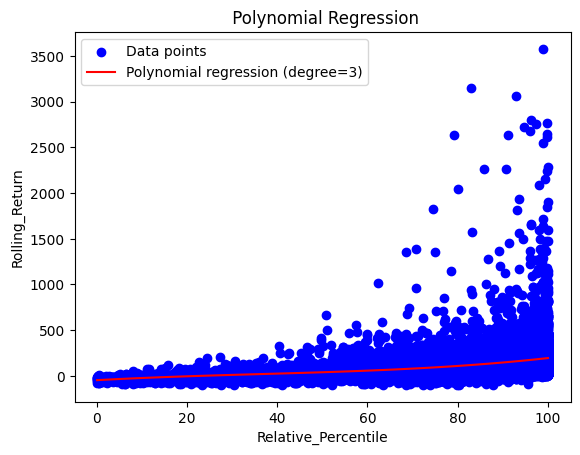

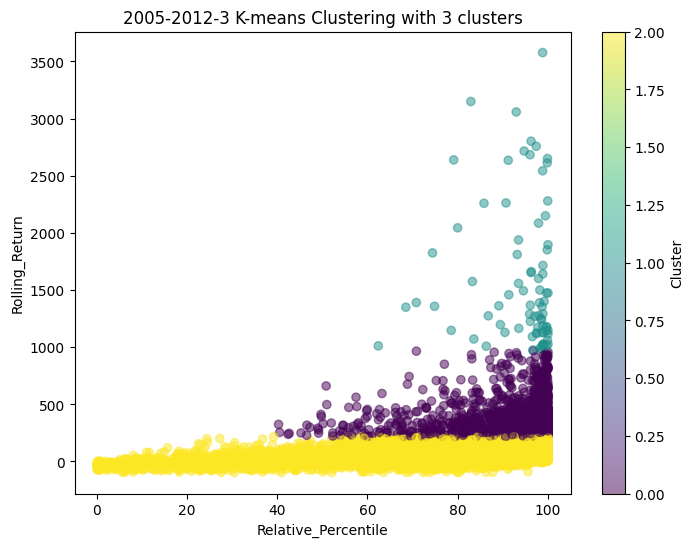

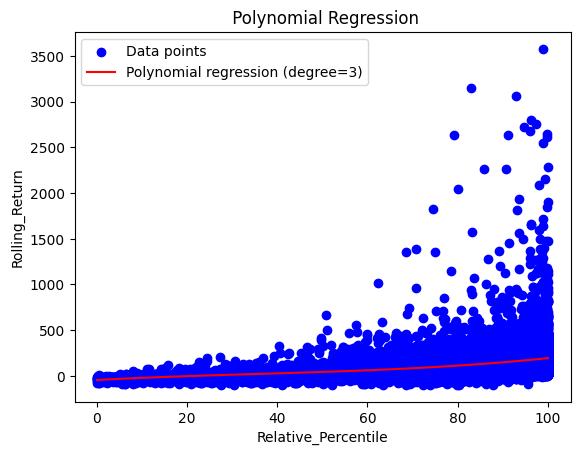

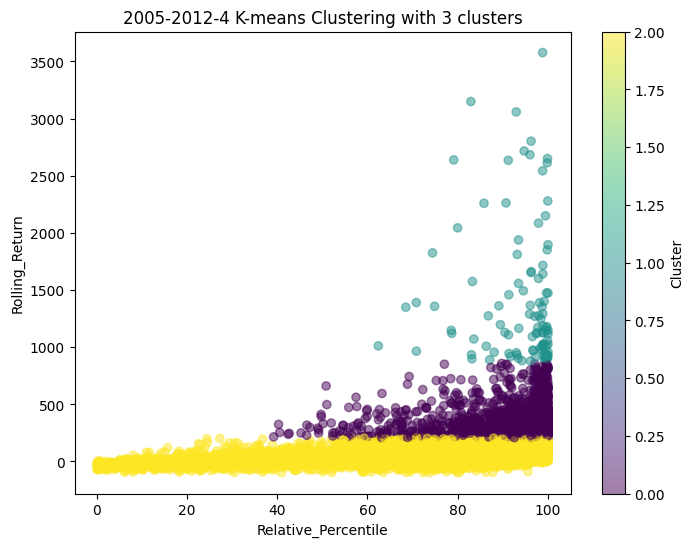

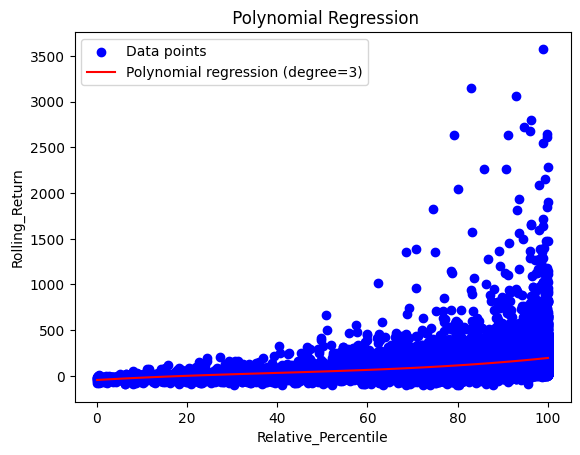

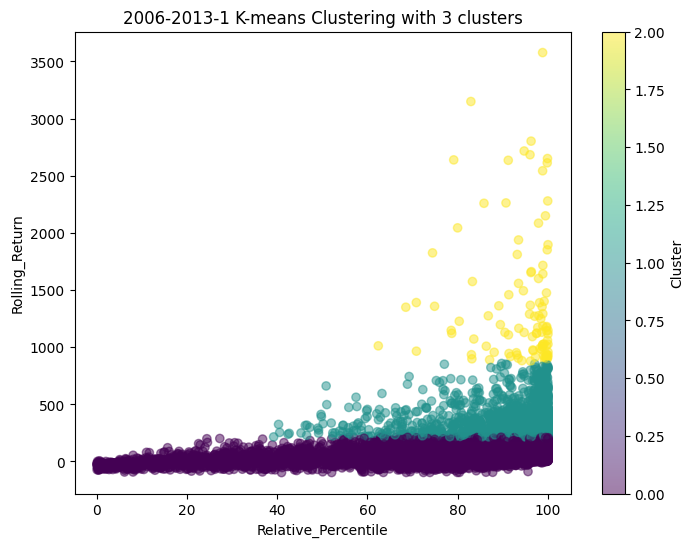

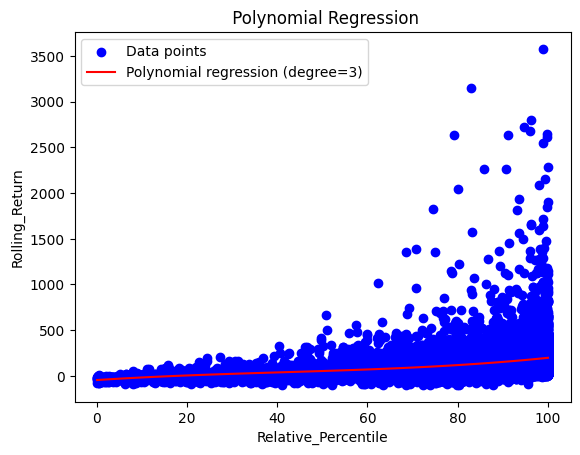

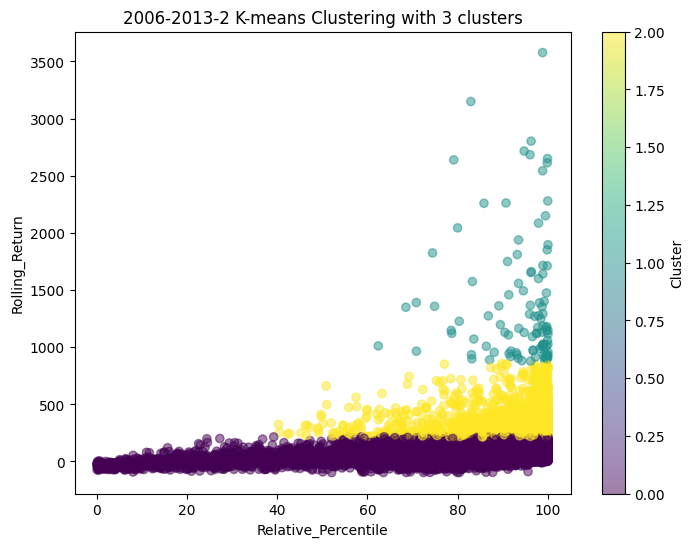

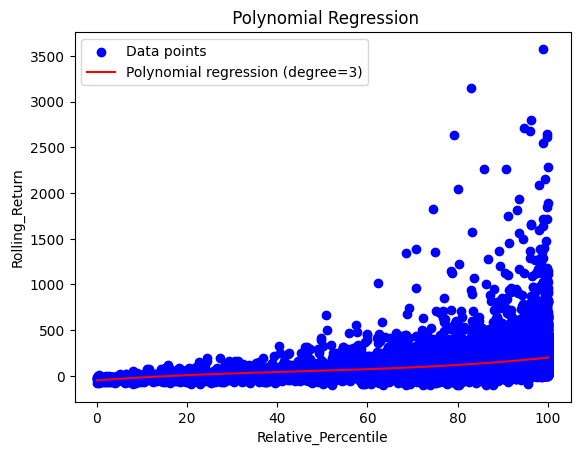

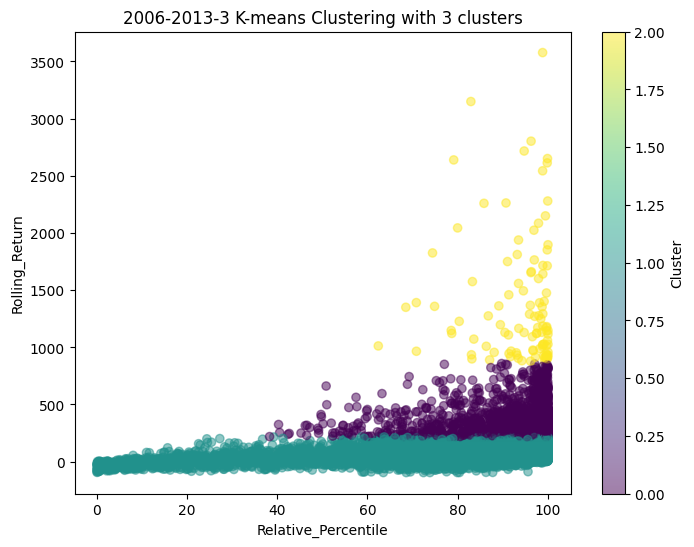

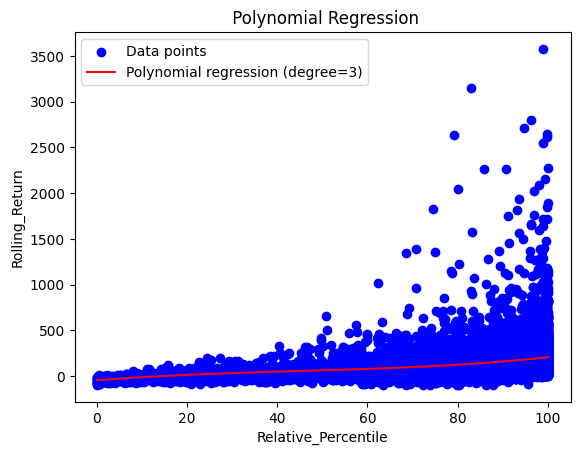

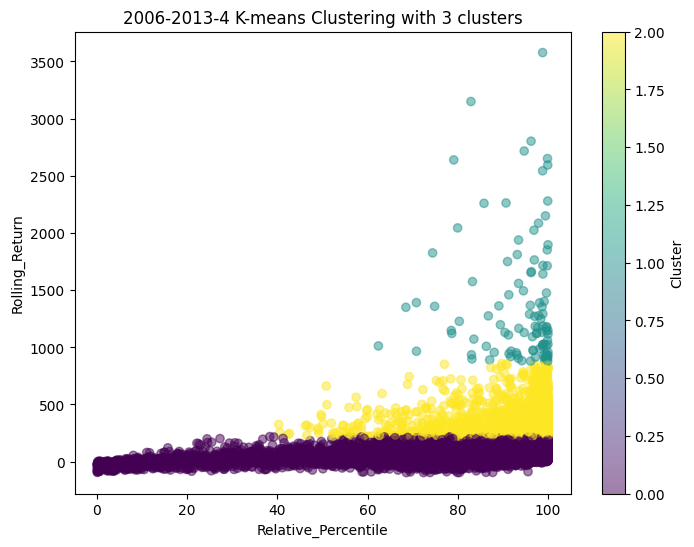

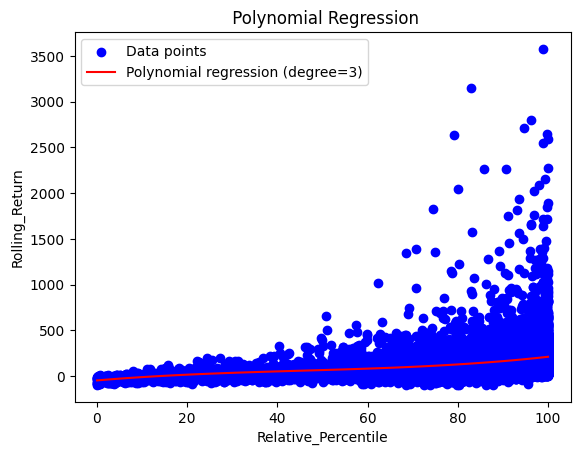

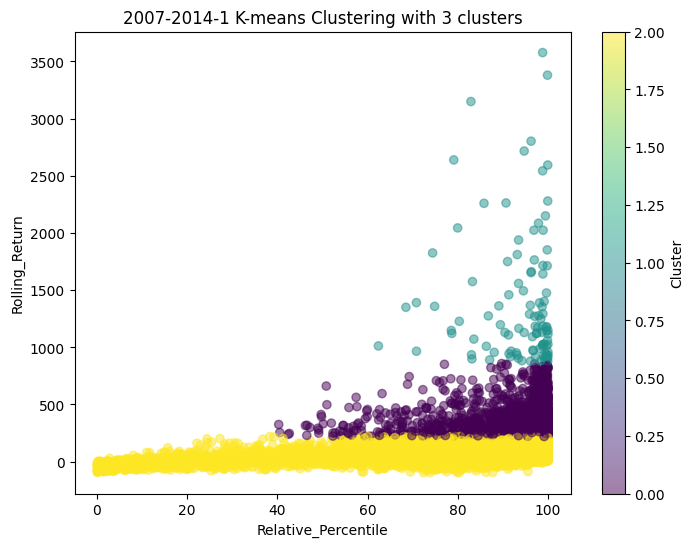

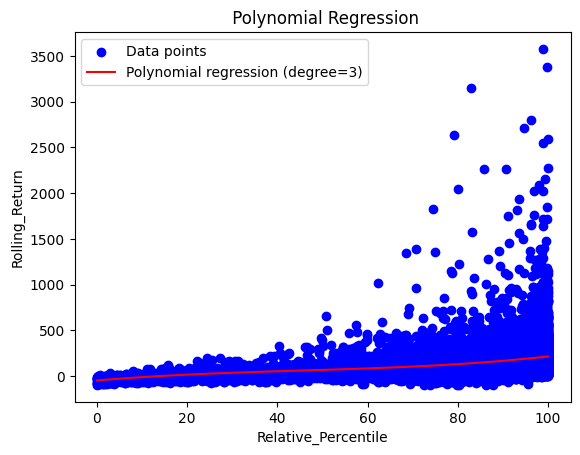

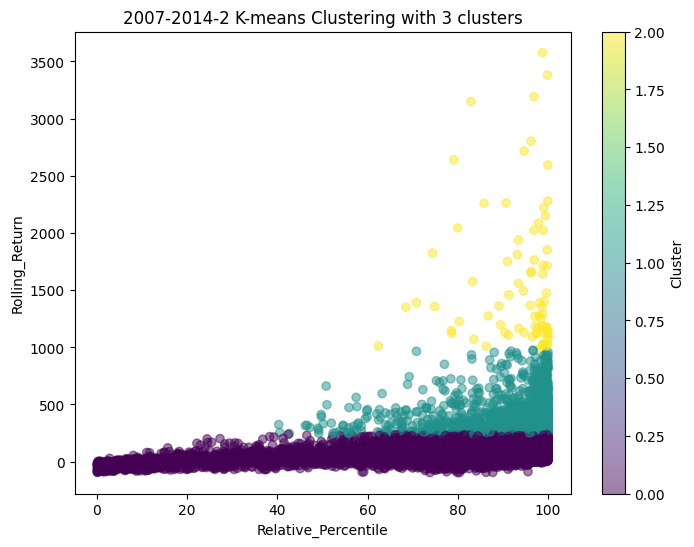

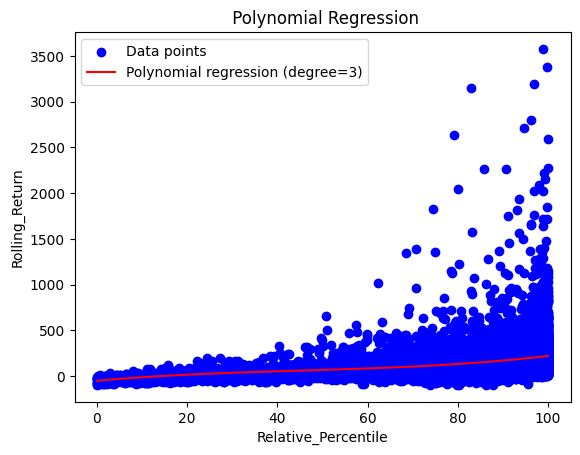

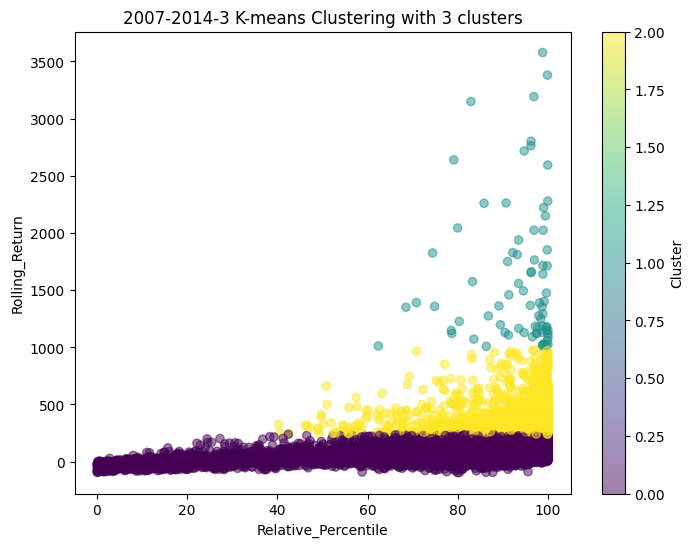

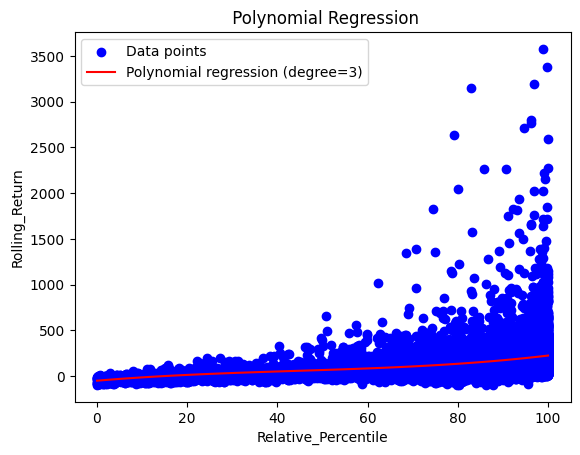

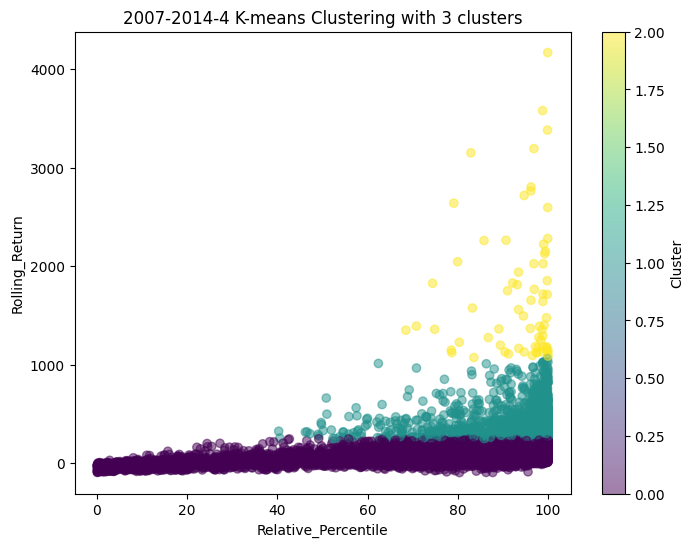

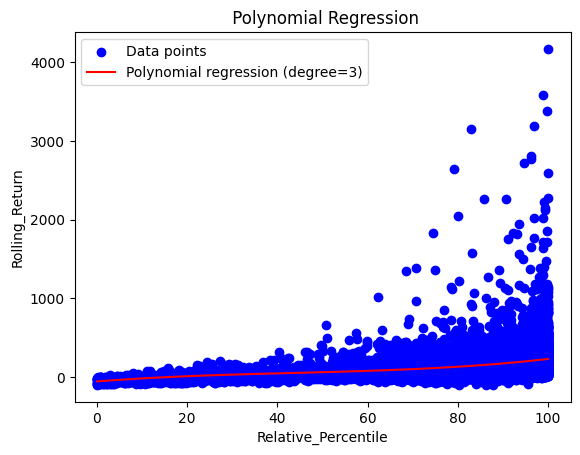

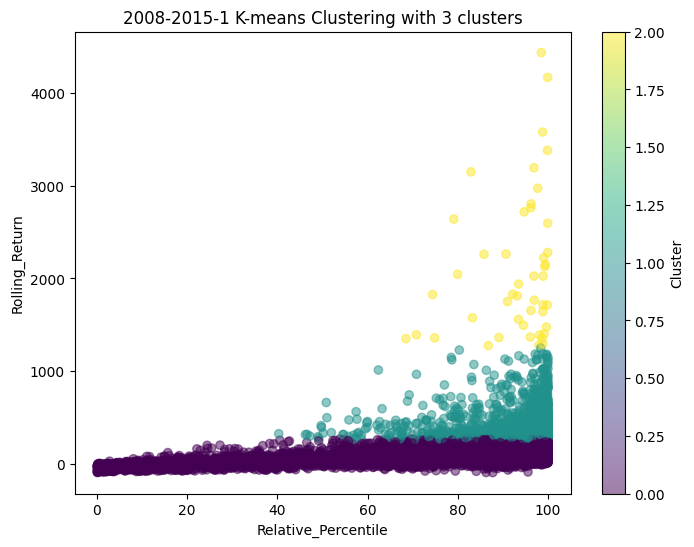

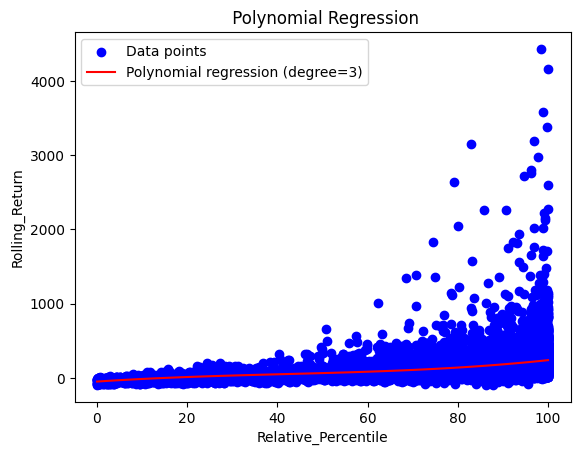

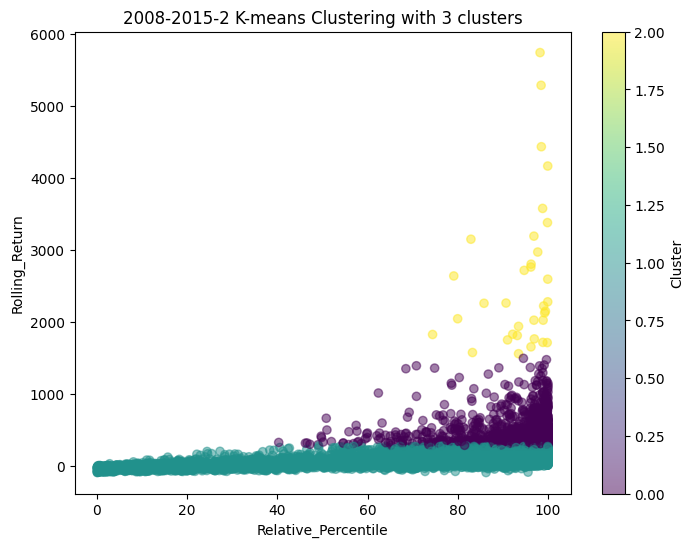

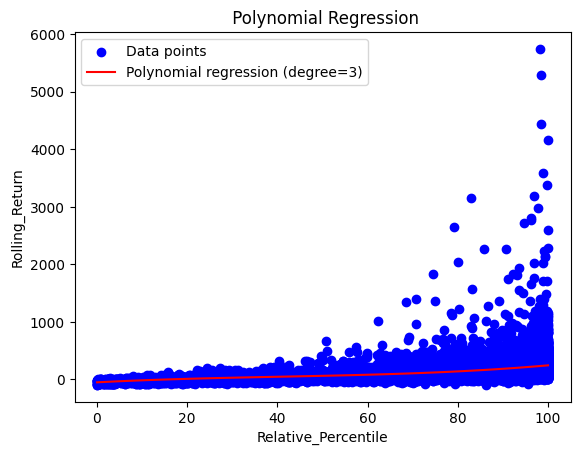

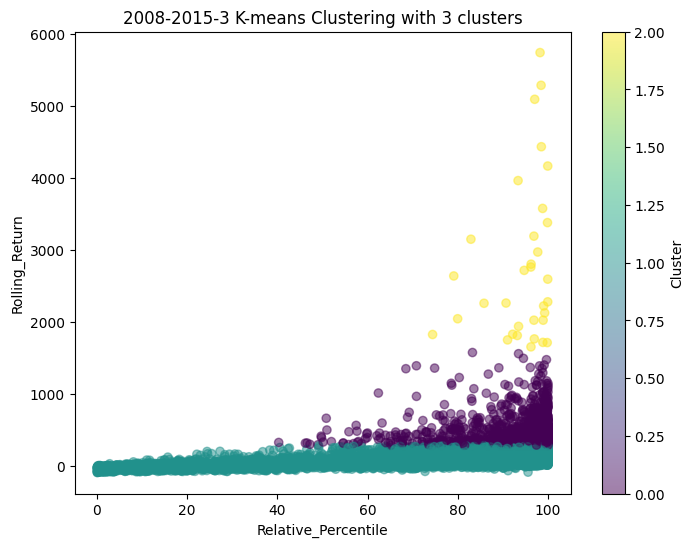

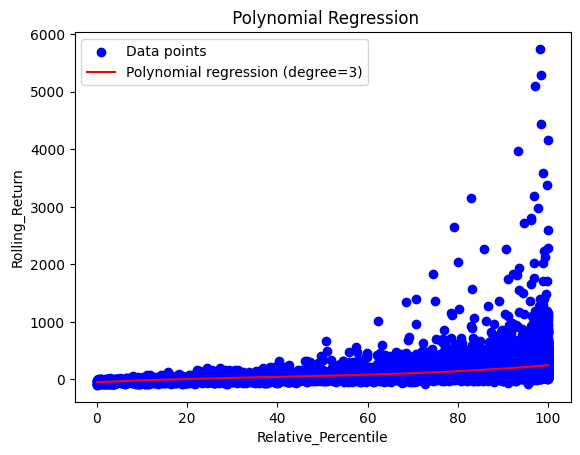

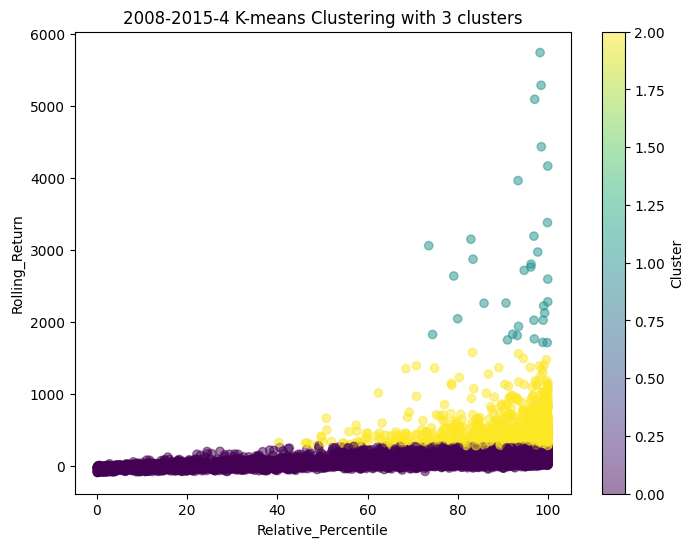

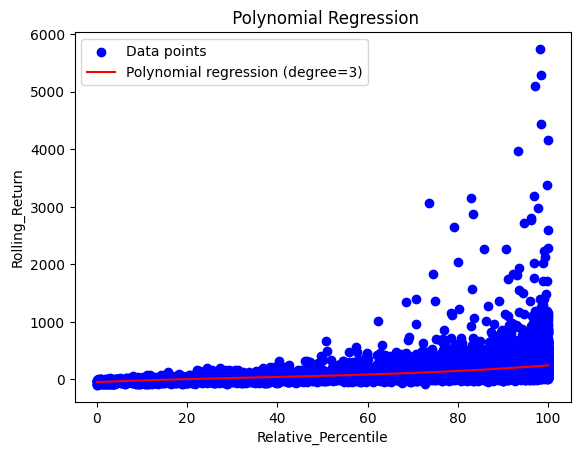

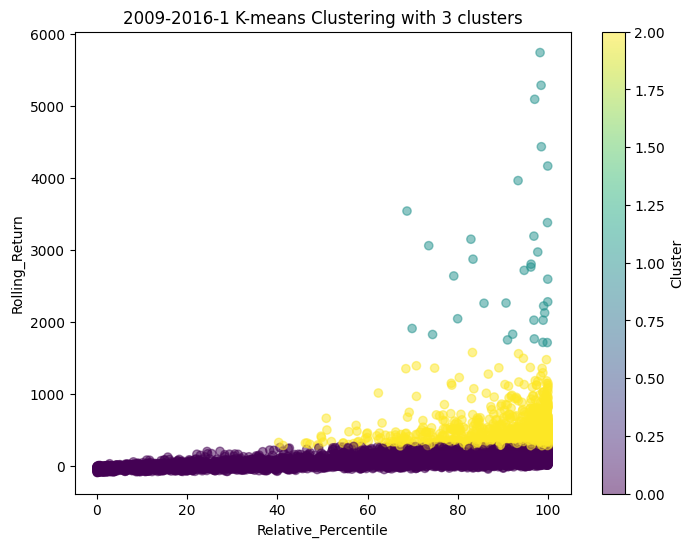

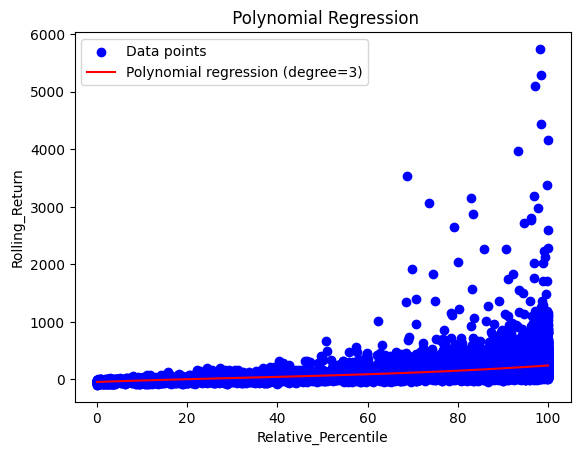

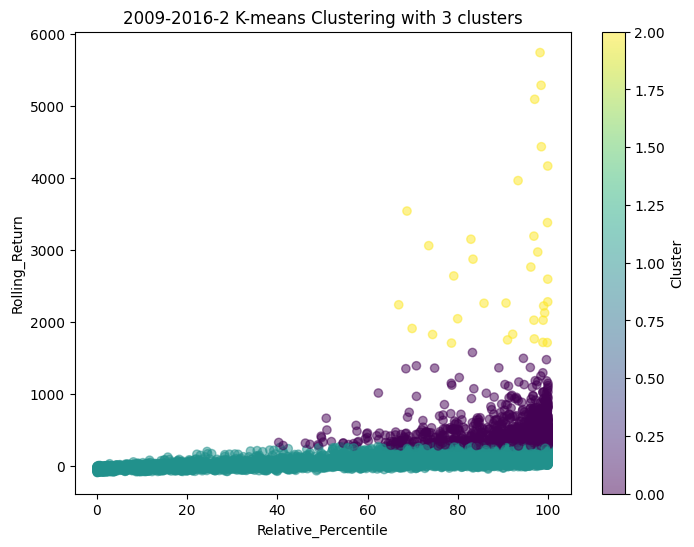

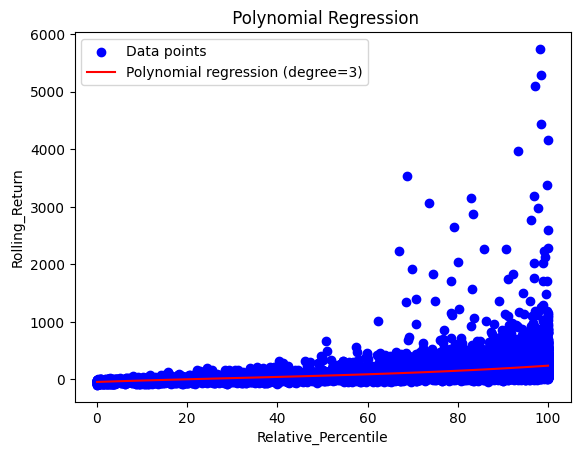

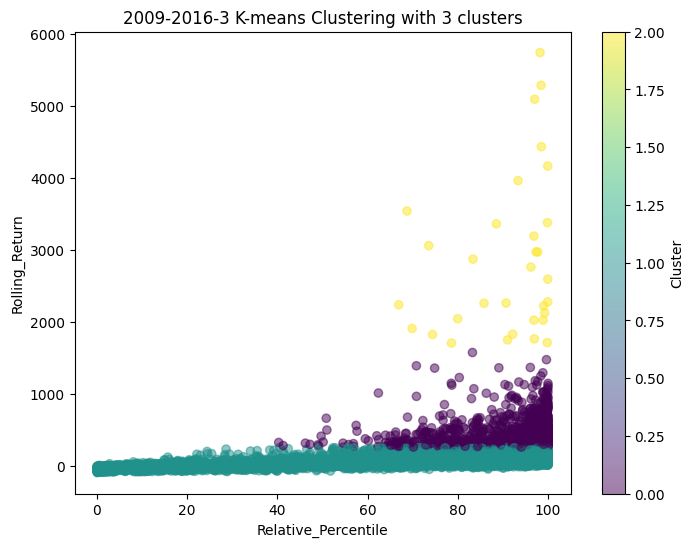

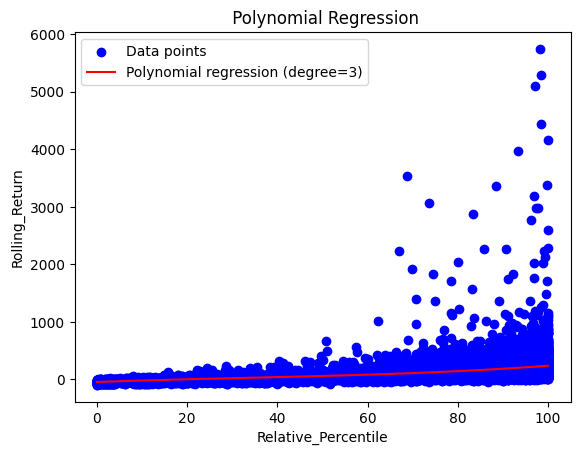

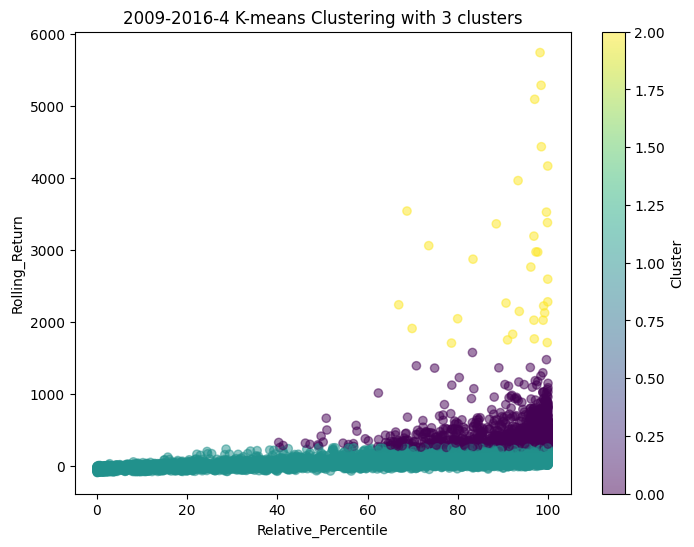

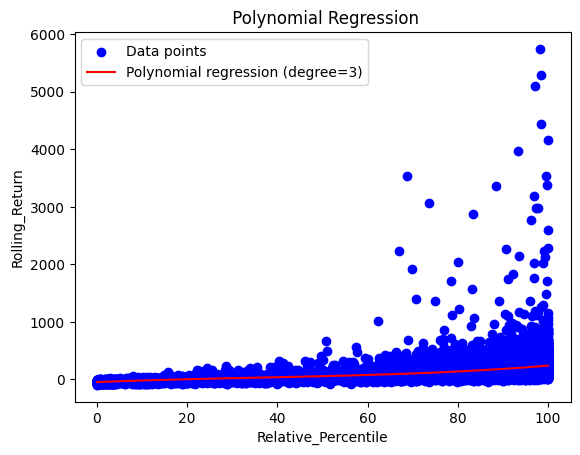

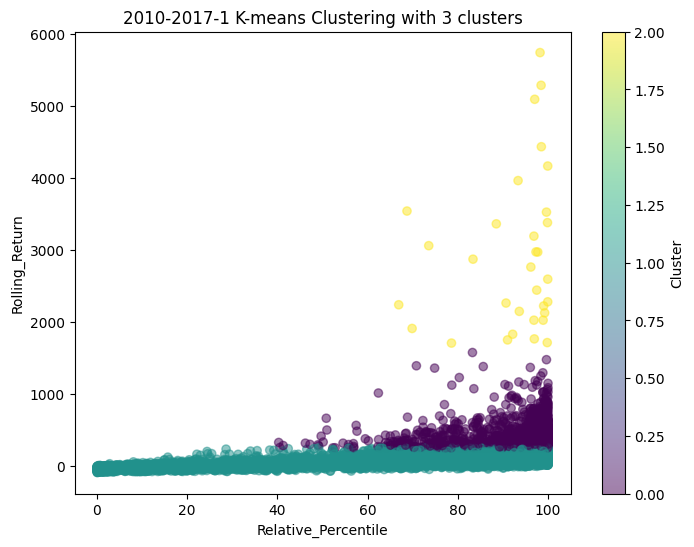

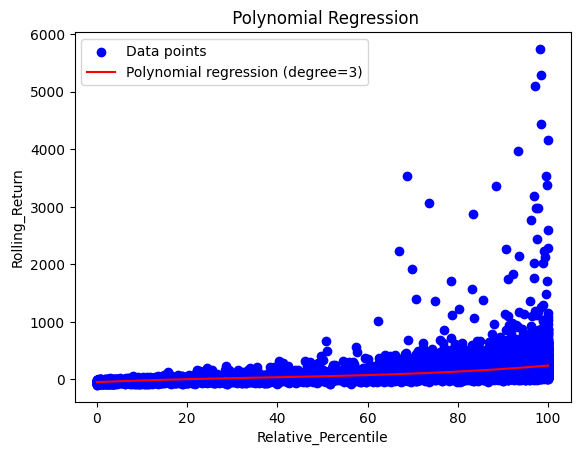

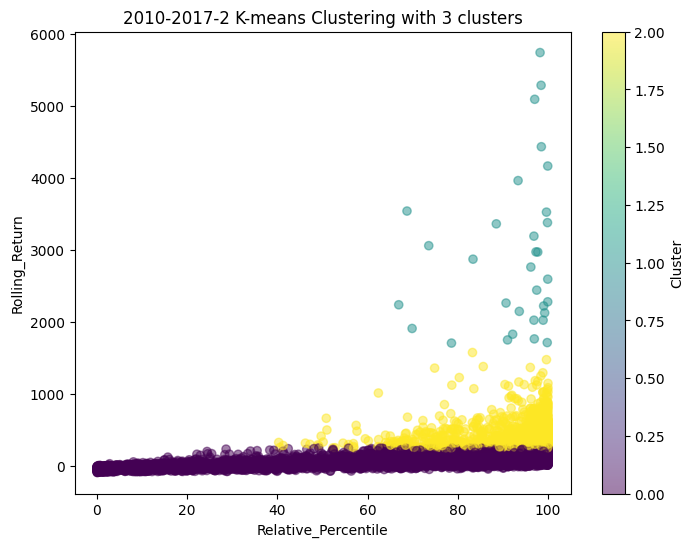

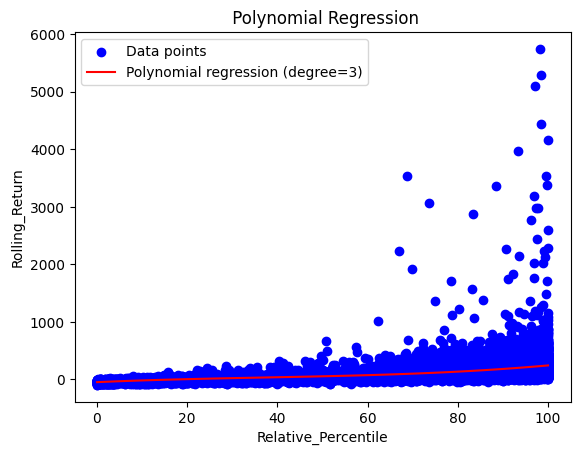

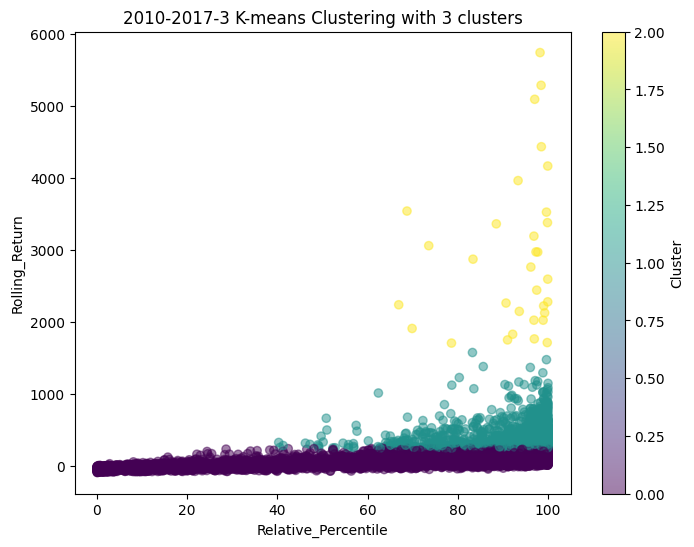

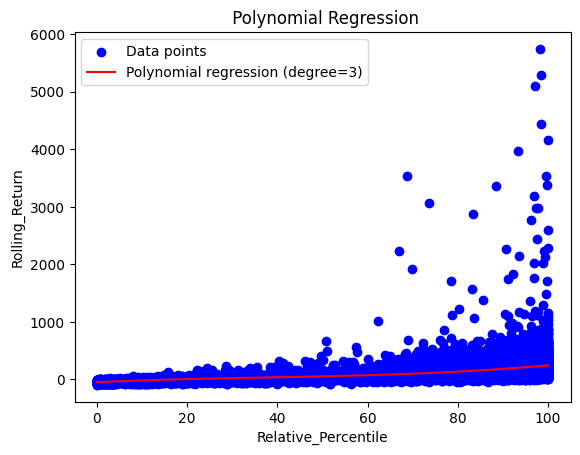

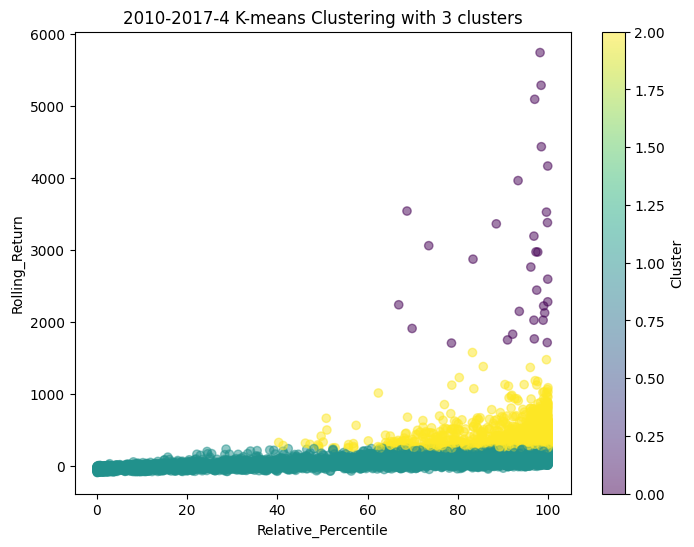

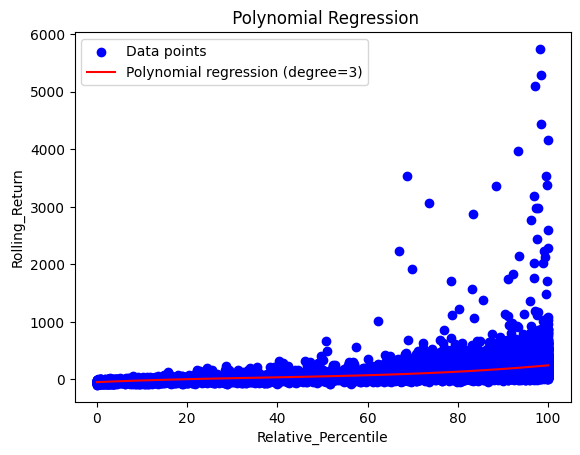

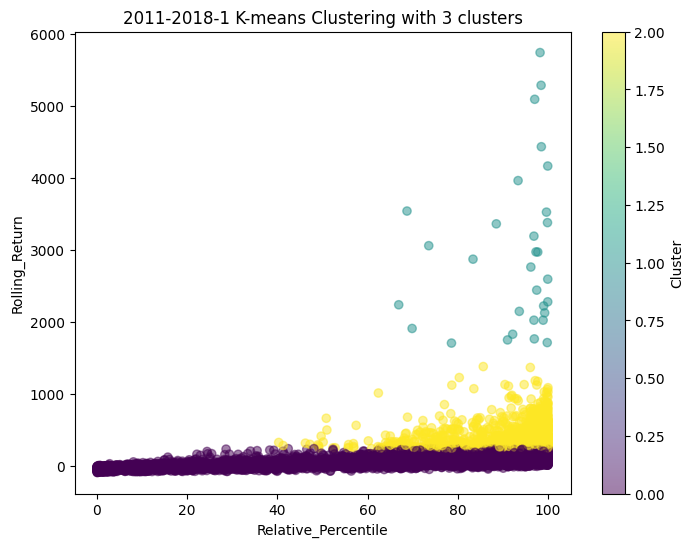

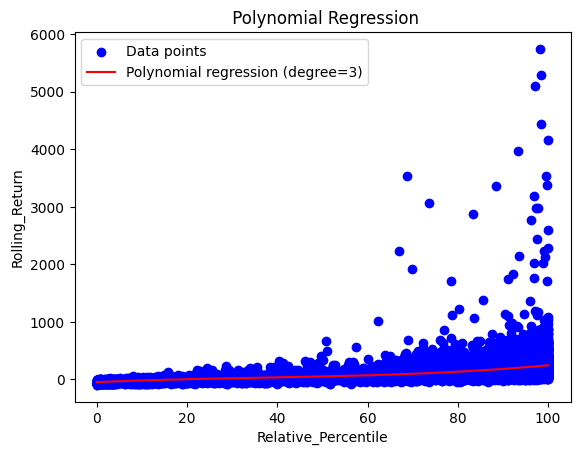

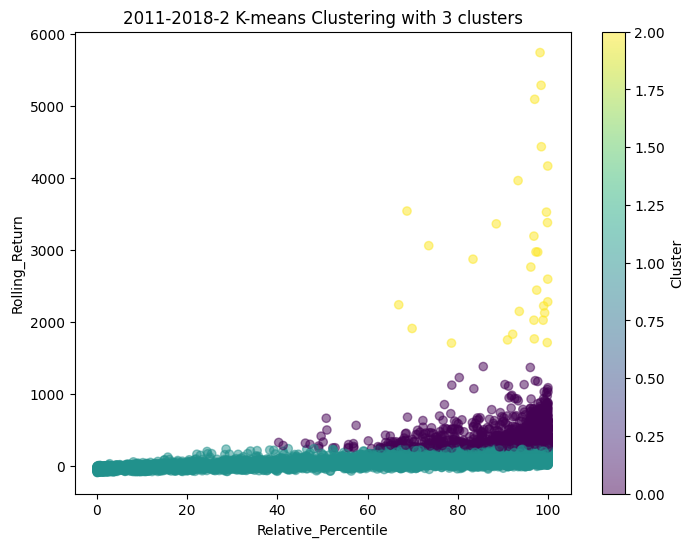

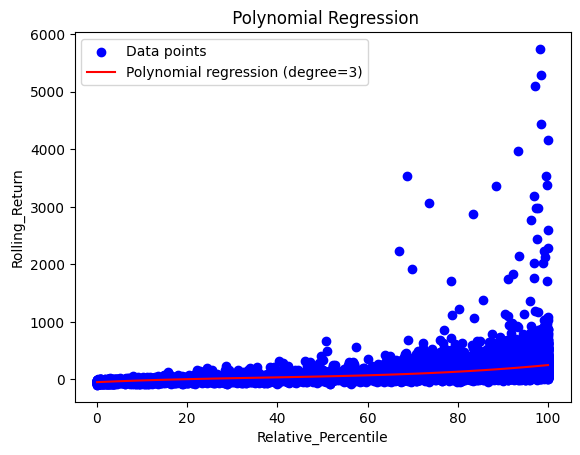

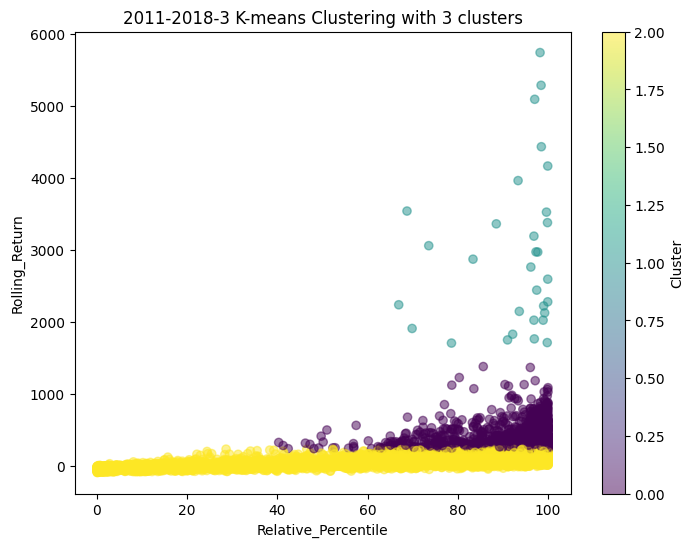

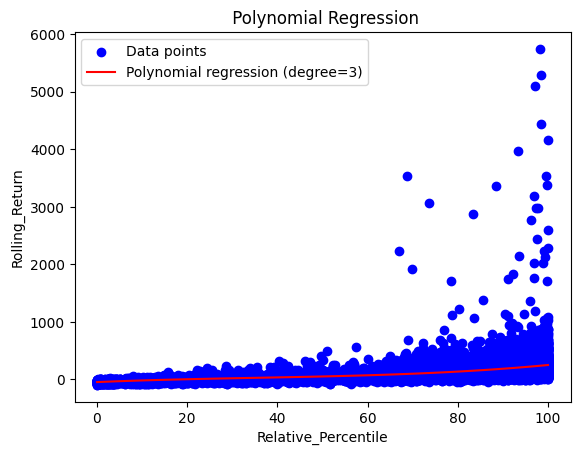

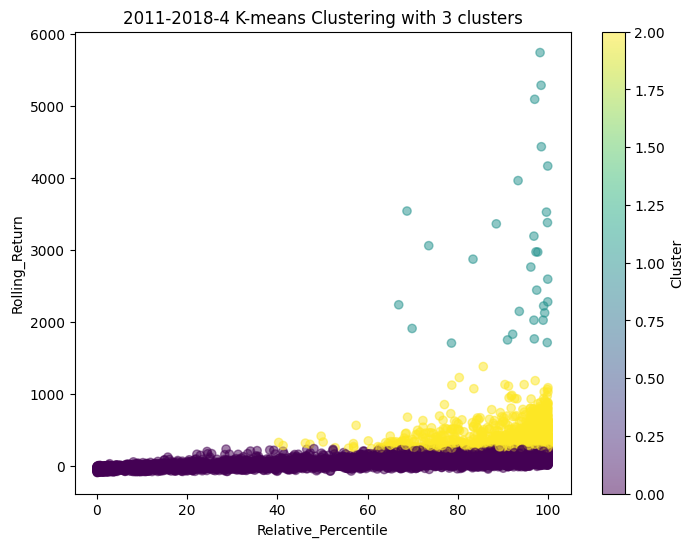

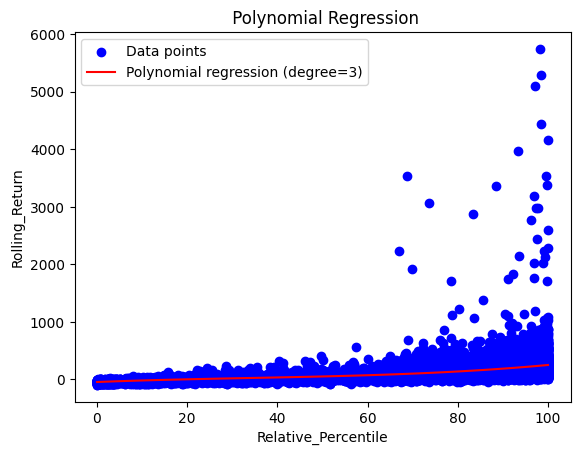

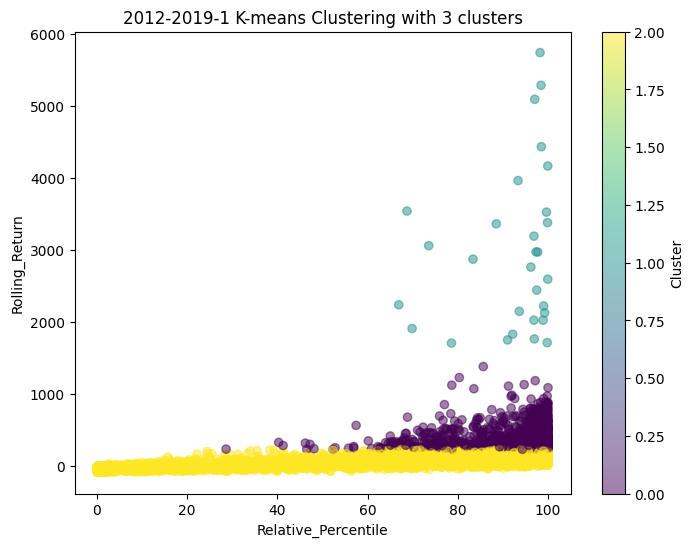

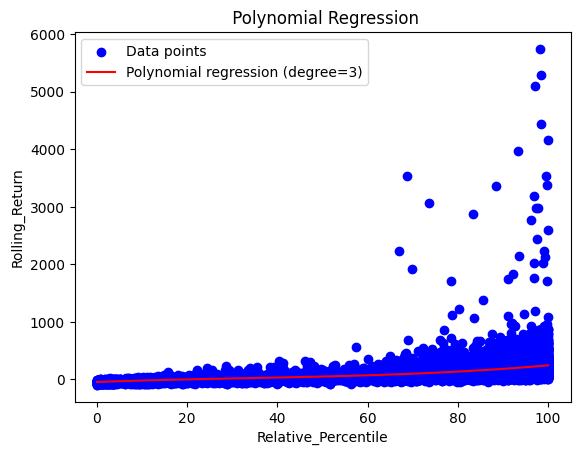

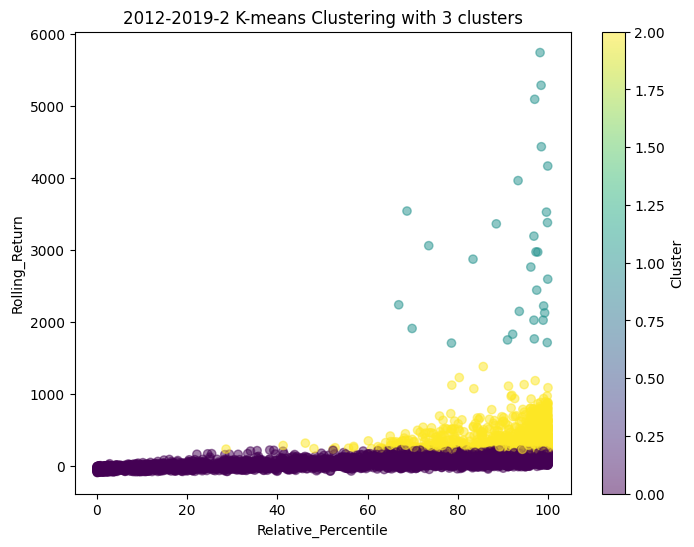

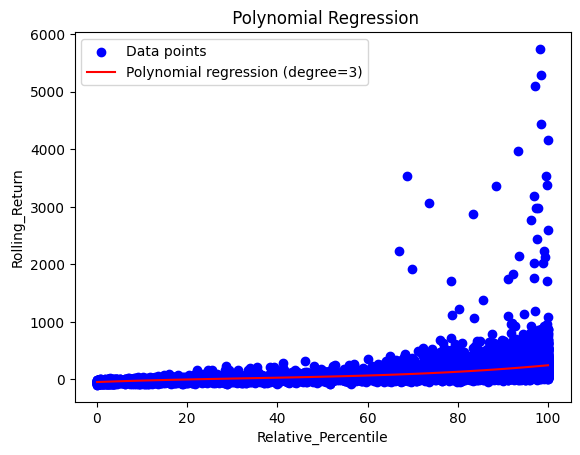

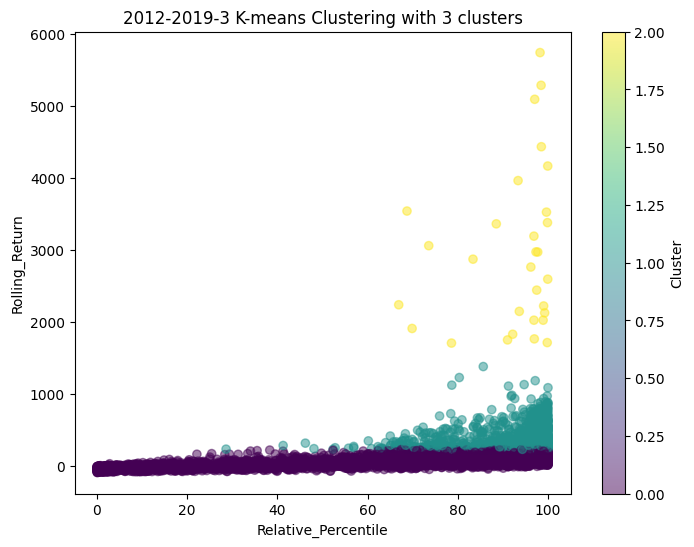

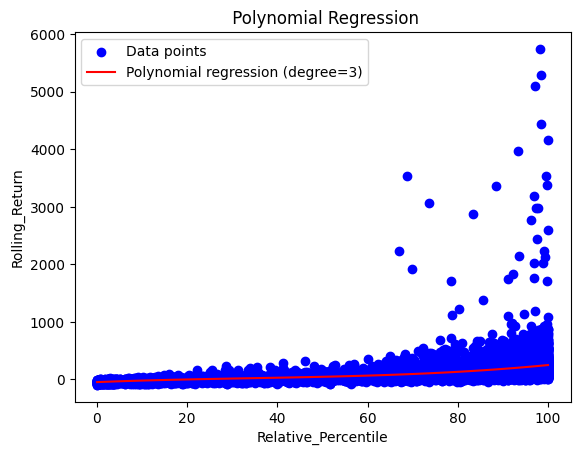

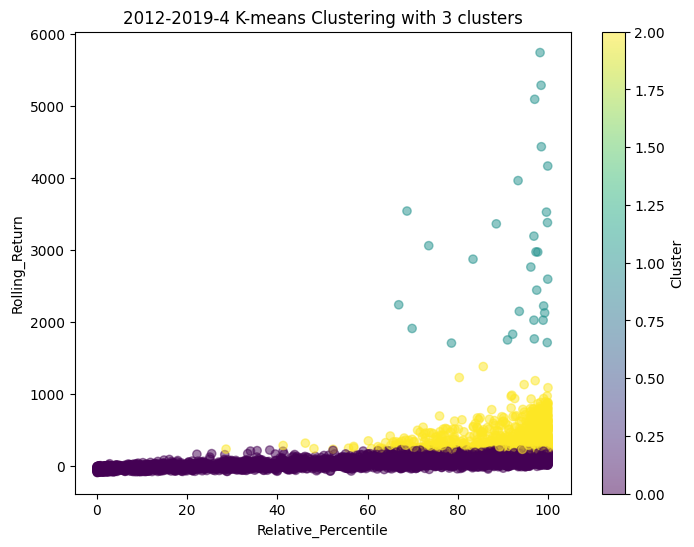

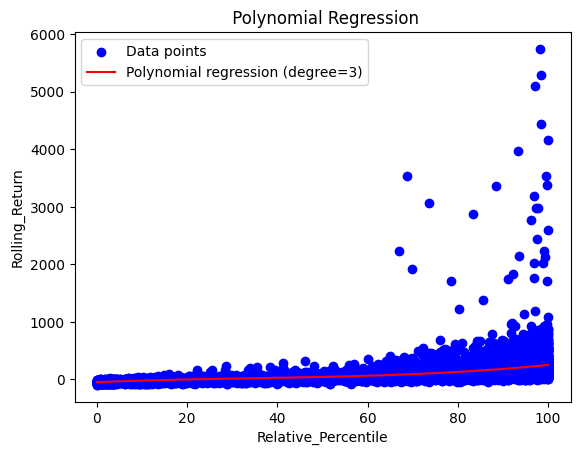

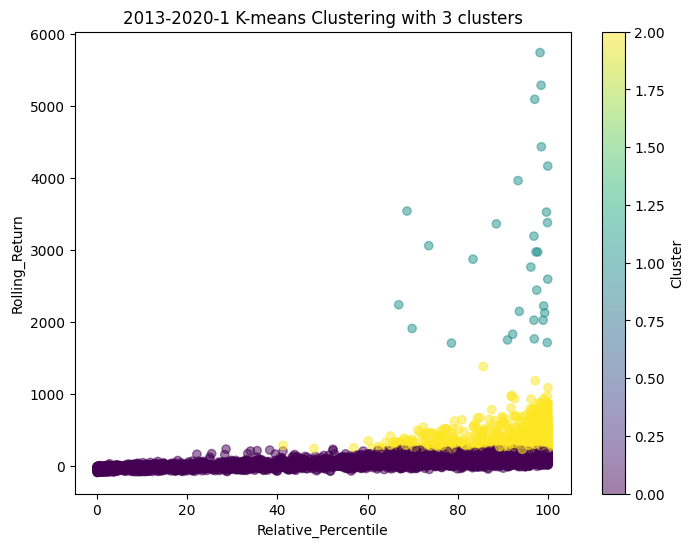

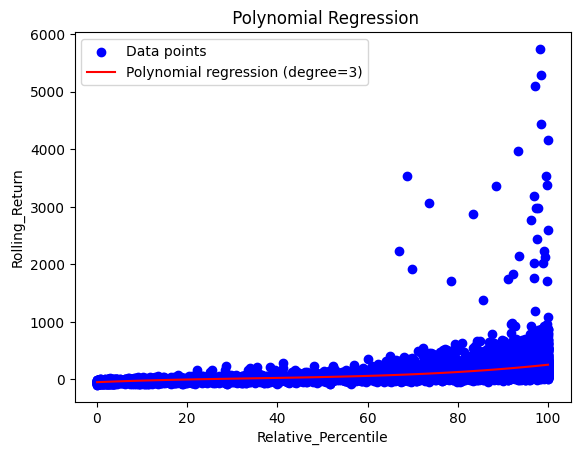

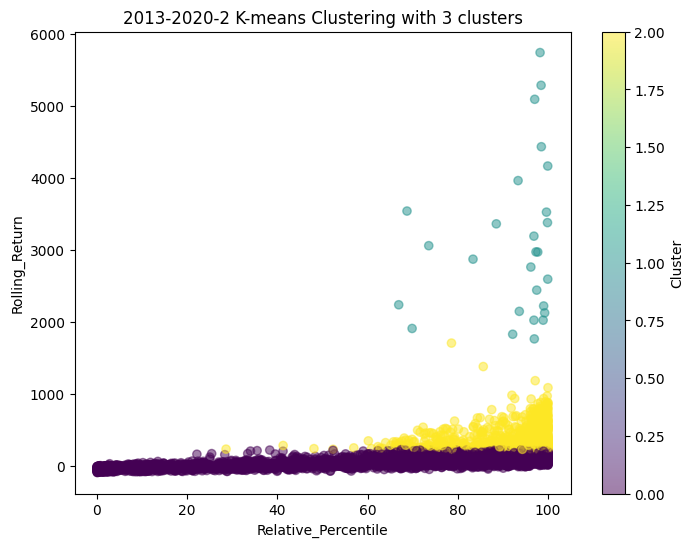

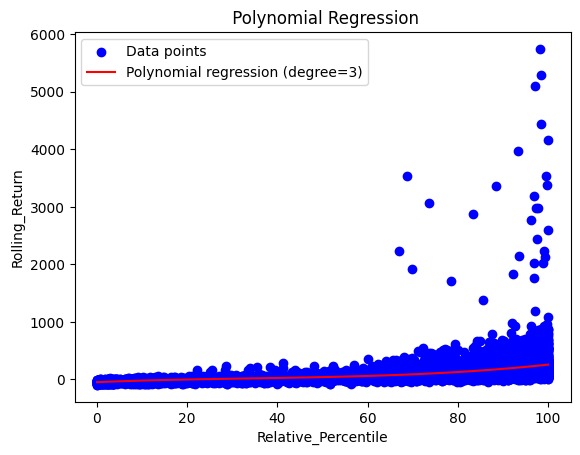

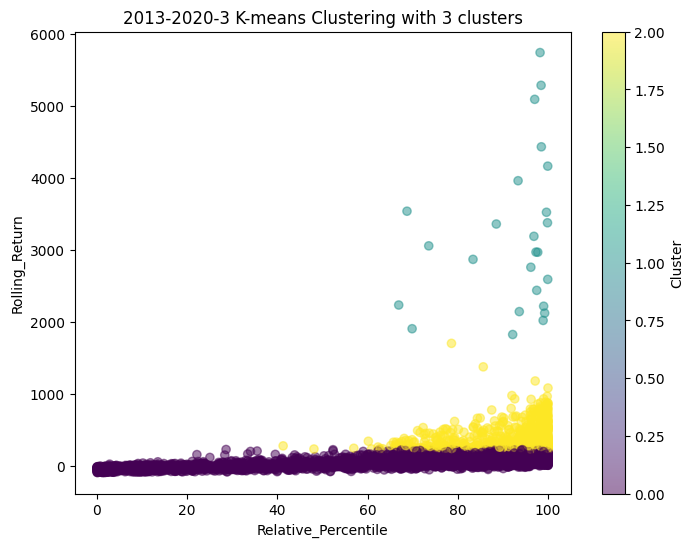

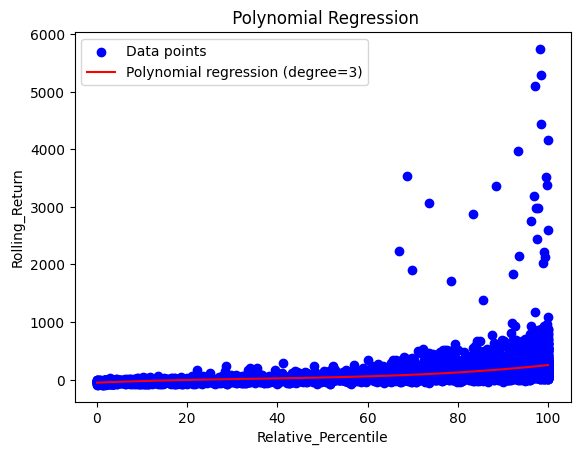

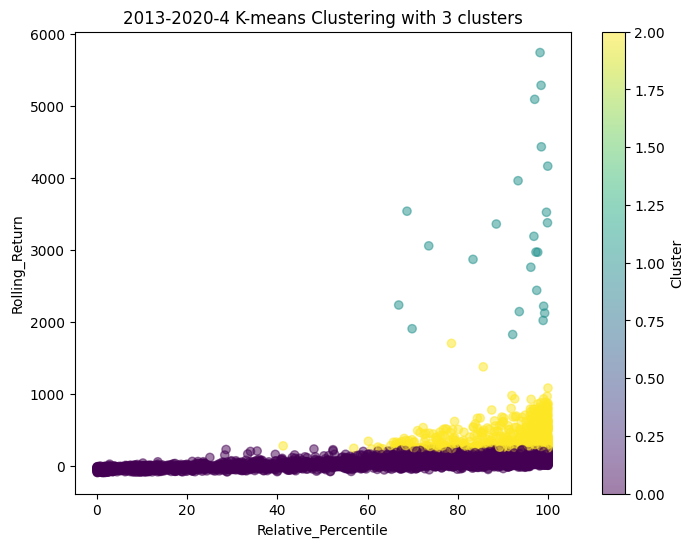

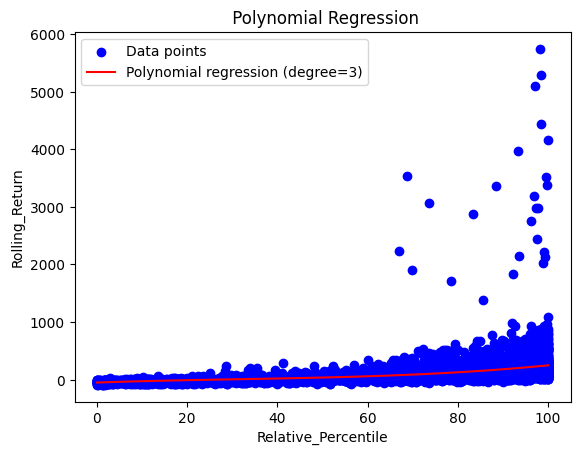

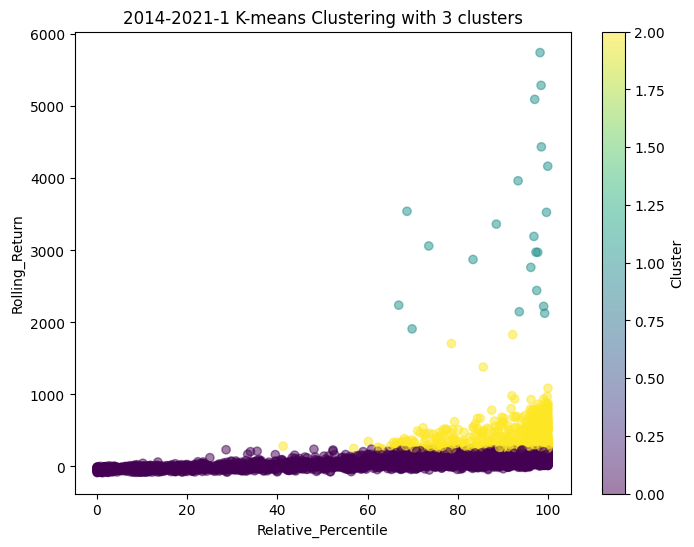

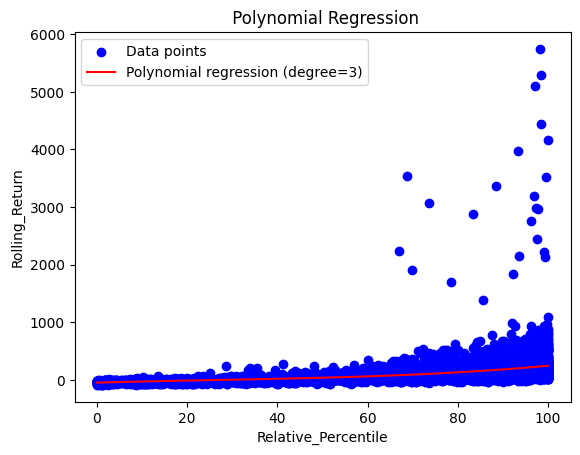

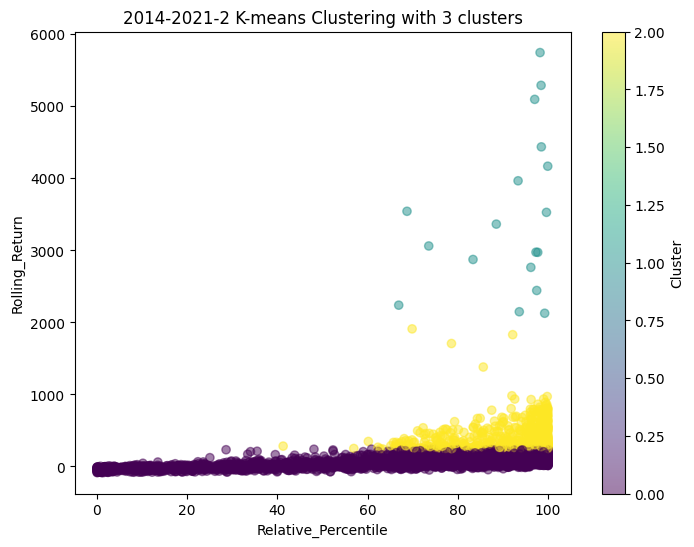

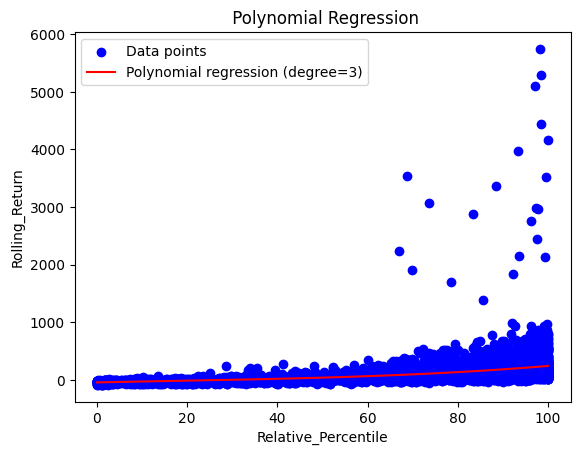

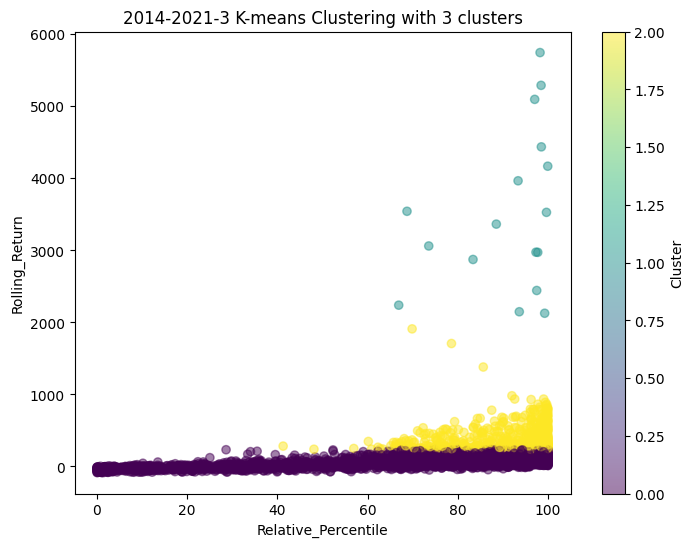

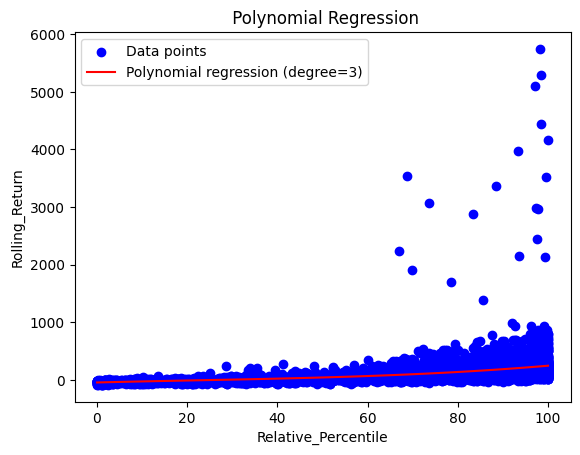

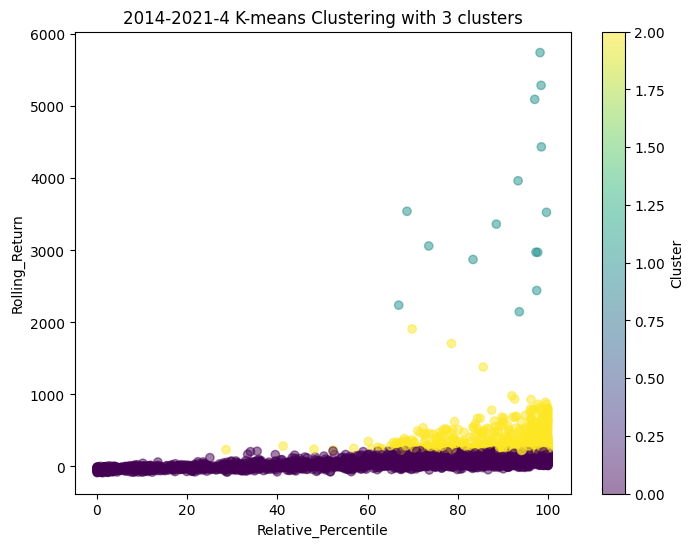

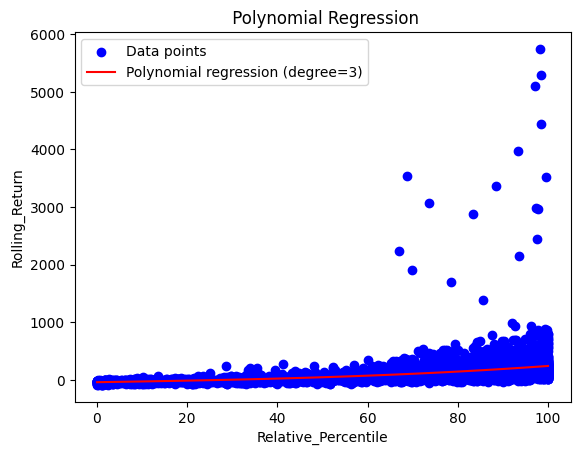

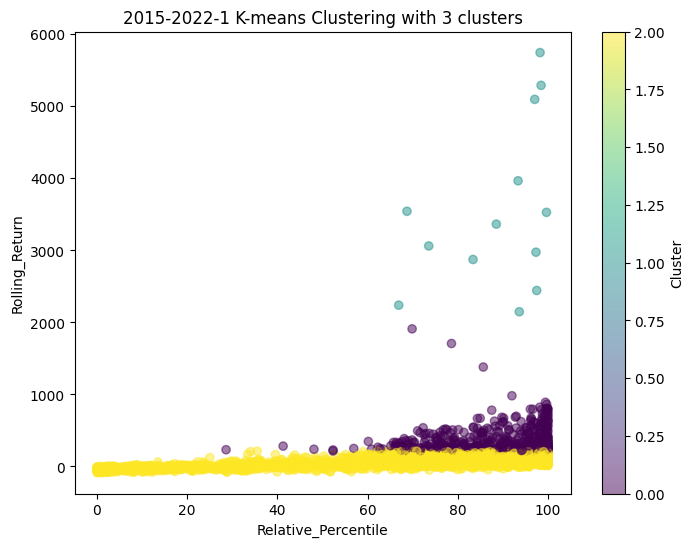

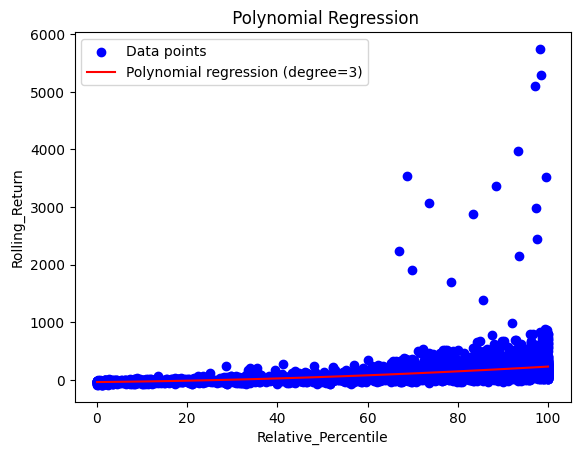

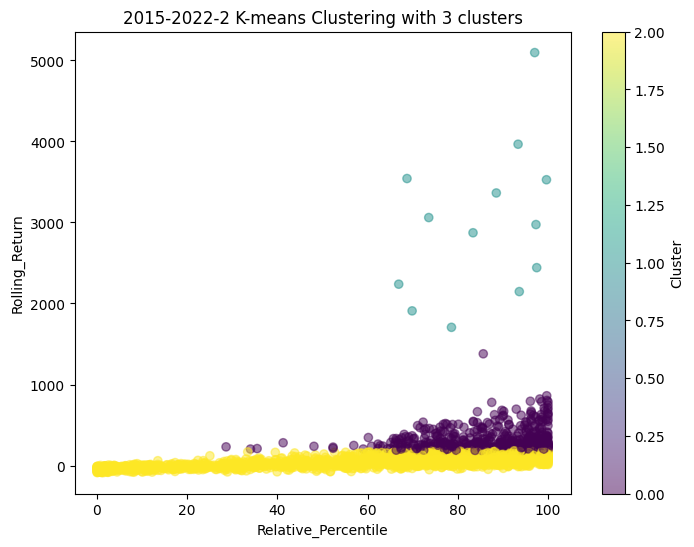

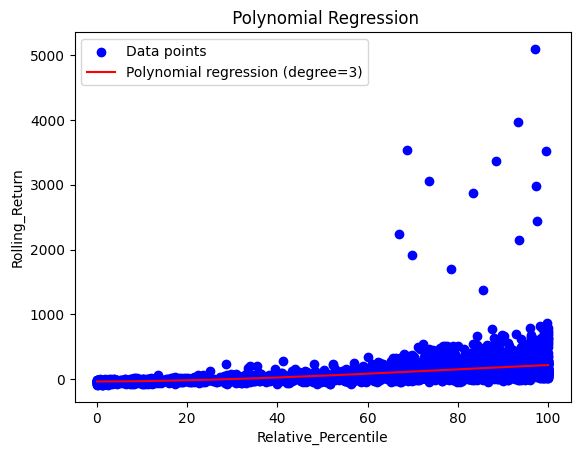

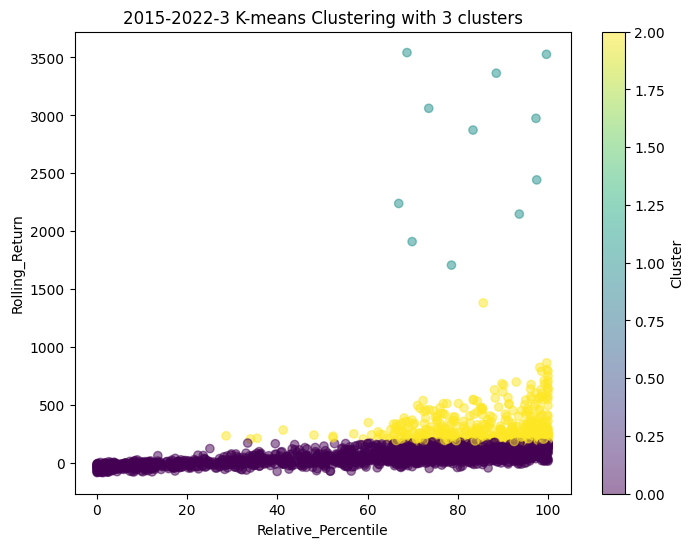

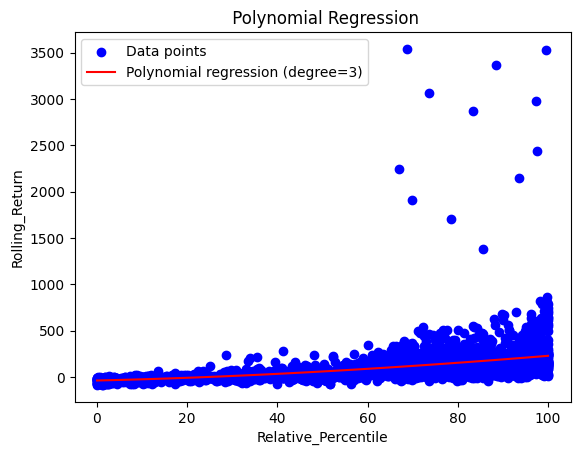

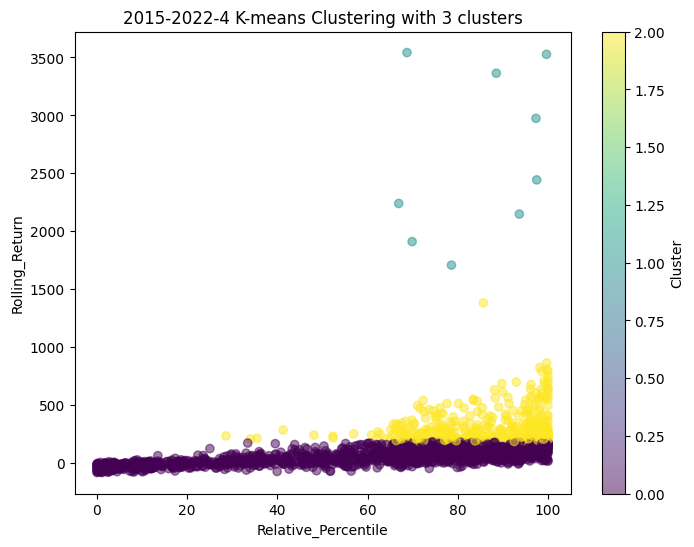

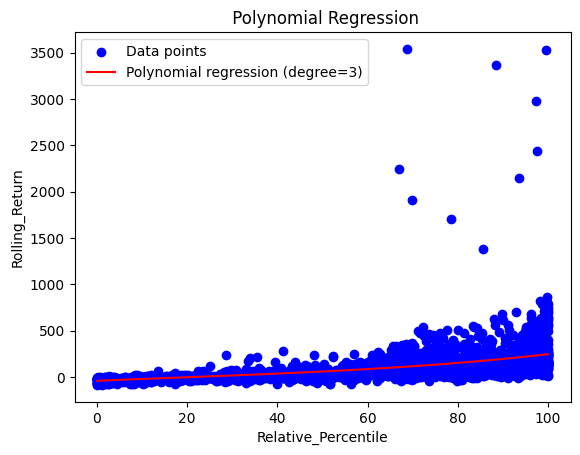

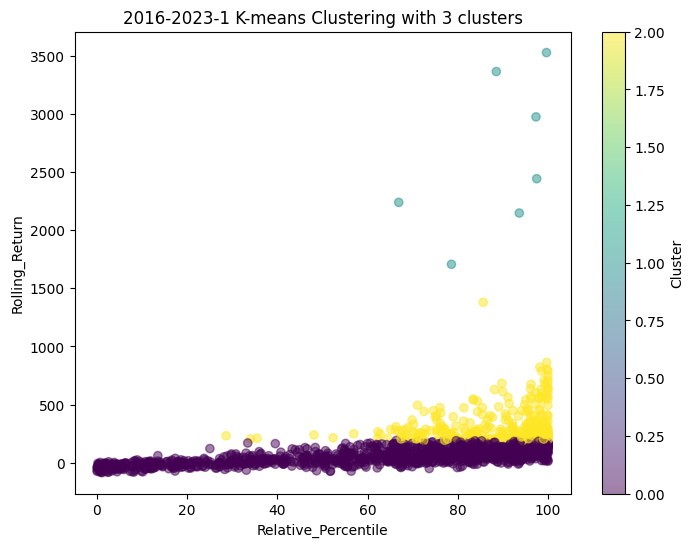

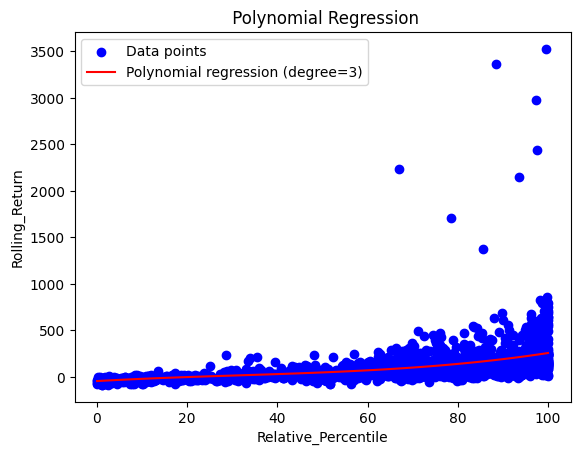

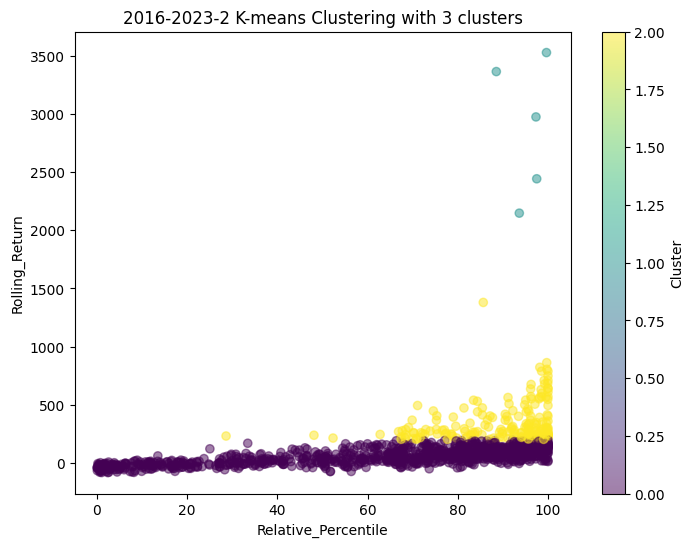

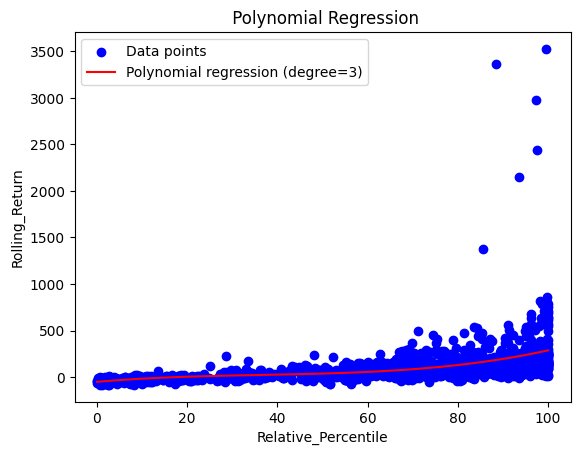

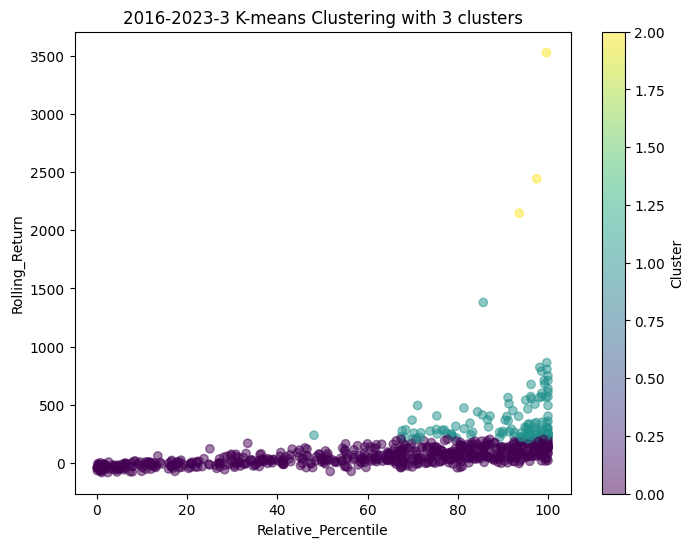

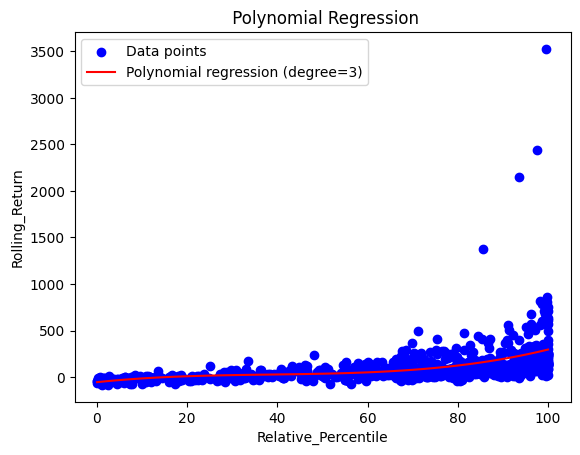

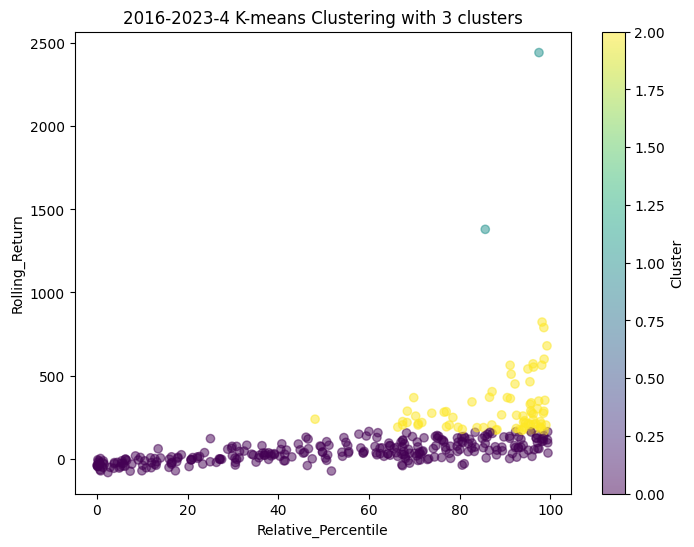

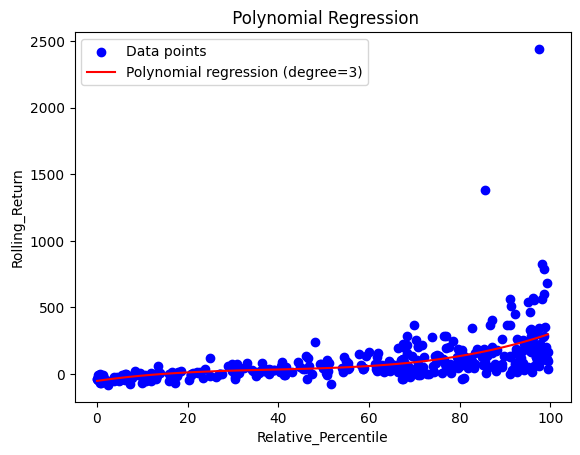

In [7]:
import numpy as np

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=2)
num_colors = 25
random_colors = np.random.rand(num_colors, 3)
index = 1
all_xs_pred = None
all_y_pred = None

for year in range(start_year, end_year): 
    for quarter in quarters:
        filtered_data_frame_1 = data_frame_rolling_percentile[((data_frame_rolling_percentile['Year'] == year) & (data_frame_rolling_percentile['Quarter'] >= quarter))]
        filtered_data_frame_2 = data_frame_rolling_percentile[((data_frame_rolling_percentile['Year'] >= year + 1) & (data_frame_rolling_percentile['Year'] <= year + 6))]
        filtered_data_frame_3 = data_frame_rolling_percentile[((data_frame_rolling_percentile['Year'] == year + 7) & (data_frame_rolling_percentile['Quarter'] < quarter))]
        
        filtered_data_frame_by_rolling = pd.concat([filtered_data_frame_1, filtered_data_frame_2, filtered_data_frame_3])
        filtered_data_frame_by_rolling = filtered_data_frame_by_rolling.reset_index(drop=True)

        if not filtered_data_frame_by_rolling.empty:
            perform_kmeans_clustering(filtered_data_frame_by_rolling, ['Relative_Percentile', 'Rolling_Return'], cmap, str(year) + '-' + str(year + 7) + '-' + str(quarter) + ' K-means Clustering with 3 clusters', save_as_image=False)
            perform_polynomial_on_clustering(filtered_data_frame_by_rolling, ['Relative_Percentile', 'Rolling_Return'], ' Polynomial Regression', save_as_image=False)
            all_xs_pred, all_y_pred = combine_polynomial_plots(filtered_data_frame_by_rolling, ['Relative_Percentile', 'Rolling_Return'], all_xs_pred, all_y_pred)

In [8]:
num_colors = 500
random_colors = []

while len(random_colors) < num_colors:
    color = np.random.rand(3)
    if not any(np.array_equal(color, existing_color) for existing_color in random_colors):
        random_colors.append(color)

random_colors = np.array(random_colors)

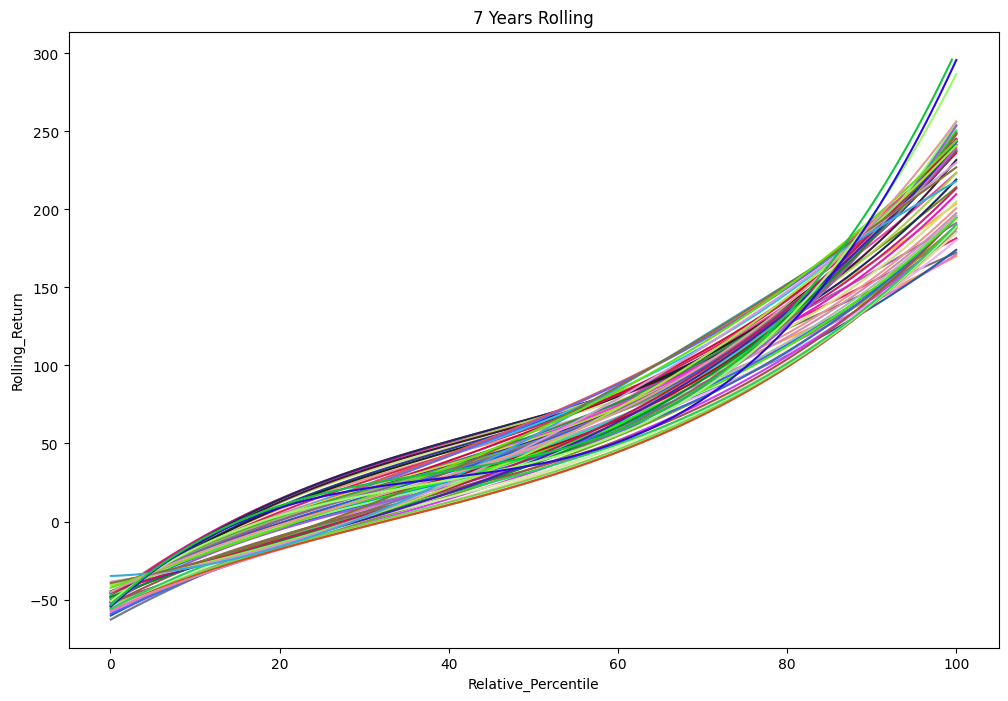

In [9]:
plt.figure(figsize=(12, 8))

index = 0
for year in range(start_year, end_year): 
    for quarter in quarters:
        plt.plot(all_xs_pred[index], all_y_pred[index], color=random_colors[index], label=str(year) + '-' + str(year + 7) + '-' + str(quarter))
        index += 1

plt.xlabel('Relative_Percentile')
plt.ylabel('Rolling_Return')
plt.title('7 Years Rolling')

num_cols = 3  

plt.savefig("7-years-rolling")
plt.show()
